## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "sapu_DR", "sapu_UR", "sapu_DL", "sapu_UL",
    "suspicious_DR", "suspicious_UR", "suspicious_DL", "suspicious_UL",
#     "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct/NoDoor/NormalizePoint/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1794, 8, 36) (1794, 1) 41.86124 151.11847

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>, 'out': <tf.Variable 'Variable_4:0' shape=(13,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *2048
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 5.100116, Accuracy = 0.046875
PERFORMANCE ON TEST SET:             Batch Loss = 4.944670677185059, Accuracy = 0.08249720931053162
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.320333, Accuracy = 0.1875
PERFORMANCE ON TEST SET:             Batch Loss = 4.230842590332031, Accuracy = 0.20066890120506287
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.091754, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 4.026116371154785, Accuracy = 0.24526198208332062
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 4.000293, Accuracy = 0.21875
PERFORMANCE ON TEST SET:             Batch Loss = 3.934616804122925, Accuracy = 0.27591973543167114
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.973303, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 3.83673095703125, Accuracy = 0.2998885214328766
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.807302, Accuracy = 0.265625
PERFO

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.718283, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.8720855712890625, Accuracy = 0.4559643268585205
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 2.968113, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.846761465072632, Accuracy = 0.45652174949645996
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.863810, Accuracy = 0.453125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8622007369995117, Accuracy = 0.4492753744125366
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 2.677540, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.8073434829711914, Accuracy = 0.46042364835739136
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 3.108340, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 2.8219399452209473, Accuracy = 0.45652174949645996
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 2.737273, Accuracy = 0.515625

Iter #46592:  Learning rate = 0.005000:   Batch Loss = 2.564719, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.417036771774292, Accuracy = 0.5172798037528992
Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.464766, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.4273853302001953, Accuracy = 0.5289855003356934
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.384231, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.4101486206054688, Accuracy = 0.5189520716667175
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.299093, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.444465160369873, Accuracy = 0.5066889524459839
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.507270, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 2.4099583625793457, Accuracy = 0.5239687561988831
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 2.460391, Accuracy = 0.5
PERFORMANCE

Iter #70144:  Learning rate = 0.005000:   Batch Loss = 2.247898, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.223339796066284, Accuracy = 0.5540691018104553
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 2.200083, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2009057998657227, Accuracy = 0.5769230723381042
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 2.203801, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.249709129333496, Accuracy = 0.5579710006713867
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.077964, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.204153299331665, Accuracy = 0.5657747983932495
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 2.285244, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.237300395965576, Accuracy = 0.5429208278656006
Iter #72704:  Learning rate = 0.005000:   Batch Loss = 2.069895, Accuracy = 0.65625

PERFORMANCE ON TEST SET:             Batch Loss = 2.0444142818450928, Accuracy = 0.5964325666427612
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 2.287963, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.050029993057251, Accuracy = 0.5942028760910034
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 2.180279, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.081956148147583, Accuracy = 0.588071346282959
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 2.257678, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.087209463119507, Accuracy = 0.5802675485610962
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 1.947306, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 2.082461357116699, Accuracy = 0.5841694474220276
Iter #95744:  Learning rate = 0.005000:   Batch Loss = 2.089962, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0558876991271973, Accuracy = 0.581

Iter #116736:  Learning rate = 0.004800:   Batch Loss = 1.876024, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9198353290557861, Accuracy = 0.6176142692565918
Iter #117248:  Learning rate = 0.004800:   Batch Loss = 1.783292, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9092403650283813, Accuracy = 0.634894073009491
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 1.869549, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9253602027893066, Accuracy = 0.6237457990646362
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 1.907577, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9118561744689941, Accuracy = 0.6282051205635071
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 2.060912, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9092321395874023, Accuracy = 0.6265329122543335
Iter #119296:  Learning rate = 0.004800:   Batch Loss = 2.070353, Accurac

Iter #140288:  Learning rate = 0.004800:   Batch Loss = 1.966826, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9277654886245728, Accuracy = 0.6170568466186523
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 1.924215, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8627713918685913, Accuracy = 0.656633198261261
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 1.924596, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8516857624053955, Accuracy = 0.6426978707313538
Iter #141824:  Learning rate = 0.004800:   Batch Loss = 1.943578, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8473454713821411, Accuracy = 0.6644369959831238
Iter #142336:  Learning rate = 0.004800:   Batch Loss = 1.793344, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8501534461975098, Accuracy = 0.6527312994003296
Iter #142848:  Learning rate = 0.004800:   Batch Loss = 2.011957, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.7433819770812988, Accuracy = 0.692307710647583
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 1.584436, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7639187574386597, Accuracy = 0.676142692565918
Iter #164864:  Learning rate = 0.004800:   Batch Loss = 1.800484, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8056532144546509, Accuracy = 0.6661092638969421
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 1.876660, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 1.79914391040802, Accuracy = 0.6477146148681641
Iter #165888:  Learning rate = 0.004800:   Batch Loss = 1.827057, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8098357915878296, Accuracy = 0.6471571922302246
Iter #166400:  Learning rate = 0.004800:   Batch Loss = 1.692684, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7843611240386963, Accur

Iter #187392:  Learning rate = 0.004800:   Batch Loss = 1.717214, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.689706802368164, Accuracy = 0.7090300917625427
Iter #187904:  Learning rate = 0.004800:   Batch Loss = 1.675871, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.6784268617630005, Accuracy = 0.7112597823143005
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 1.794582, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7100706100463867, Accuracy = 0.7056856155395508
Iter #188928:  Learning rate = 0.004800:   Batch Loss = 1.758183, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7041776180267334, Accuracy = 0.7073578834533691
Iter #189440:  Learning rate = 0.004800:   Batch Loss = 1.866163, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6938648223876953, Accuracy = 0.7079152464866638
Iter #189952:  Learning rate = 0.004800:   Batch Loss = 1.833531, Accuracy = 0.67

Iter #210944:  Learning rate = 0.004608:   Batch Loss = 1.679373, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7681477069854736, Accuracy = 0.6789297461509705
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 1.537574, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7602424621582031, Accuracy = 0.6767001152038574
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 1.671063, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.73952054977417, Accuracy = 0.6934224963188171
Iter #212480:  Learning rate = 0.004608:   Batch Loss = 1.723812, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.715649127960205, Accuracy = 0.6889632344245911
Iter #212992:  Learning rate = 0.004608:   Batch Loss = 1.944082, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7105236053466797, Accuracy = 0.7012262940406799
Iter #213504:  Learning rate = 0.004608:   Batch Loss = 1.771666, Accuracy

Iter #234496:  Learning rate = 0.004608:   Batch Loss = 1.646530, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6672744750976562, Accuracy = 0.7251951098442078
Iter #235008:  Learning rate = 0.004608:   Batch Loss = 1.595711, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6673121452331543, Accuracy = 0.7157190442085266
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 1.694648, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6303691864013672, Accuracy = 0.7335562705993652
Iter #236032:  Learning rate = 0.004608:   Batch Loss = 1.515622, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6449036598205566, Accuracy = 0.7251951098442078
Iter #236544:  Learning rate = 0.004608:   Batch Loss = 1.609583, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.64373779296875, Accuracy = 0.7329989075660706
Iter #237056:  Learning rate = 0.004608:   Batch Loss = 1.692955, Accurac

Iter #257536:  Learning rate = 0.004608:   Batch Loss = 1.627190, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5707459449768066, Accuracy = 0.7491638660430908
Iter #258048:  Learning rate = 0.004608:   Batch Loss = 1.367421, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5536167621612549, Accuracy = 0.7603121399879456
Iter #258560:  Learning rate = 0.004608:   Batch Loss = 1.634395, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5756655931472778, Accuracy = 0.7513935565948486
Iter #259072:  Learning rate = 0.004608:   Batch Loss = 1.507717, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5752896070480347, Accuracy = 0.7469342350959778
Iter #259584:  Learning rate = 0.004608:   Batch Loss = 1.537335, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5558626651763916, Accuracy = 0.7625418305397034
Iter #260096:  Learning rate = 0.004608:   Batch Loss = 1.418851, Accur

Iter #281088:  Learning rate = 0.004608:   Batch Loss = 1.466491, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.585134506225586, Accuracy = 0.7474916577339172
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 1.522531, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6048855781555176, Accuracy = 0.7408027052879333
Iter #282112:  Learning rate = 0.004608:   Batch Loss = 1.714096, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5957539081573486, Accuracy = 0.7441471815109253
Iter #282624:  Learning rate = 0.004608:   Batch Loss = 1.562301, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6017065048217773, Accuracy = 0.741360068321228
Iter #283136:  Learning rate = 0.004608:   Batch Loss = 1.569339, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.562389612197876, Accuracy = 0.7525083422660828
Iter #283648:  Learning rate = 0.004608:   Batch Loss = 1.536007, Accuracy = 0.7

Iter #303616:  Learning rate = 0.004424:   Batch Loss = 1.763208, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5938712358474731, Accuracy = 0.7408027052879333
Iter #304128:  Learning rate = 0.004424:   Batch Loss = 1.595789, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.571901559829712, Accuracy = 0.7430323362350464
Iter #304640:  Learning rate = 0.004424:   Batch Loss = 1.742379, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5571444034576416, Accuracy = 0.7536231875419617
Iter #305152:  Learning rate = 0.004424:   Batch Loss = 1.598216, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5764102935791016, Accuracy = 0.7603121399879456
Iter #305664:  Learning rate = 0.004424:   Batch Loss = 1.382597, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5661852359771729, Accuracy = 0.7469342350959778
Iter #306176:  Learning rate = 0.004424:   Batch Loss = 1.564208, Accuracy = 0

Iter #327168:  Learning rate = 0.004424:   Batch Loss = 1.633074, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6754952669143677, Accuracy = 0.7001115083694458
Iter #327680:  Learning rate = 0.004424:   Batch Loss = 1.736103, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6388262510299683, Accuracy = 0.7129319906234741
Iter #328192:  Learning rate = 0.004424:   Batch Loss = 1.669963, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6190662384033203, Accuracy = 0.7279821634292603
Iter #328704:  Learning rate = 0.004424:   Batch Loss = 1.609280, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5819945335388184, Accuracy = 0.741360068321228
Iter #329216:  Learning rate = 0.004424:   Batch Loss = 1.453856, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5753827095031738, Accuracy = 0.7402452826499939
Iter #329728:  Learning rate = 0.004424:   Batch Loss = 1.656239, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.50615656375885, Accuracy = 0.7647714614868164
Iter #350720:  Learning rate = 0.004424:   Batch Loss = 1.391850, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.510275959968567, Accuracy = 0.7681159377098083
Iter #351232:  Learning rate = 0.004424:   Batch Loss = 1.571076, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4931111335754395, Accuracy = 0.7792642116546631
Iter #351744:  Learning rate = 0.004424:   Batch Loss = 1.637055, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5004825592041016, Accuracy = 0.7736901044845581
Iter #352256:  Learning rate = 0.004424:   Batch Loss = 1.588773, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5228886604309082, Accuracy = 0.7670010924339294
Iter #352768:  Learning rate = 0.004424:   Batch Loss = 1.354156, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.516352891921997, Accuracy

Iter #373760:  Learning rate = 0.004424:   Batch Loss = 1.603328, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.545616626739502, Accuracy = 0.7480490803718567
Iter #374272:  Learning rate = 0.004424:   Batch Loss = 1.477120, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5314712524414062, Accuracy = 0.7625418305397034
Iter #374784:  Learning rate = 0.004424:   Batch Loss = 1.388238, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5129368305206299, Accuracy = 0.7753623127937317
Iter #375296:  Learning rate = 0.004424:   Batch Loss = 1.415931, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5454936027526855, Accuracy = 0.7547380328178406
Iter #375808:  Learning rate = 0.004424:   Batch Loss = 1.836484, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.559831976890564, Accuracy = 0.7525083422660828
Iter #376320:  Learning rate = 0.004424:   Batch Loss = 1.627562, Accuracy

Iter #397312:  Learning rate = 0.004424:   Batch Loss = 1.635061, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6019747257232666, Accuracy = 0.7380155920982361
Iter #397824:  Learning rate = 0.004424:   Batch Loss = 1.584889, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6032956838607788, Accuracy = 0.7335562705993652
Iter #398336:  Learning rate = 0.004424:   Batch Loss = 1.598512, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6013906002044678, Accuracy = 0.7430323362350464
Iter #398848:  Learning rate = 0.004424:   Batch Loss = 1.646699, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5754613876342773, Accuracy = 0.7430323362350464
Iter #399360:  Learning rate = 0.004424:   Batch Loss = 1.342529, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5451064109802246, Accuracy = 0.758639931678772
Iter #399872:  Learning rate = 0.004424:   Batch Loss = 1.570961, Accuracy =

Iter #420864:  Learning rate = 0.004247:   Batch Loss = 1.361035, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5219638347625732, Accuracy = 0.7575250864028931
Iter #421376:  Learning rate = 0.004247:   Batch Loss = 1.441224, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.520304799079895, Accuracy = 0.7564102411270142
Iter #421888:  Learning rate = 0.004247:   Batch Loss = 1.281891, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5976876020431519, Accuracy = 0.7408027052879333
Iter #422400:  Learning rate = 0.004247:   Batch Loss = 1.525850, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.681748628616333, Accuracy = 0.7118171453475952
Iter #422912:  Learning rate = 0.004247:   Batch Loss = 1.745749, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6989831924438477, Accuracy = 0.6962096095085144
Iter #423424:  Learning rate = 0.004247:   Batch Loss = 1.598705, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.5456395149230957, Accuracy = 0.7430323362350464
Iter #443904:  Learning rate = 0.004247:   Batch Loss = 1.581428, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4936609268188477, Accuracy = 0.7675585150718689
Iter #444416:  Learning rate = 0.004247:   Batch Loss = 1.269703, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.534106969833374, Accuracy = 0.7530657649040222
Iter #444928:  Learning rate = 0.004247:   Batch Loss = 1.468991, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.476938009262085, Accuracy = 0.7798216342926025
Iter #445440:  Learning rate = 0.004247:   Batch Loss = 1.395823, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5131653547286987, Accuracy = 0.7569676637649536
Iter #445952:  Learning rate = 0.004247:   Batch Loss = 1.473614, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5010747909545898, Accu

Iter #466944:  Learning rate = 0.004247:   Batch Loss = 1.506717, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4380097389221191, Accuracy = 0.7798216342926025
Iter #467456:  Learning rate = 0.004247:   Batch Loss = 1.455567, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4067507982254028, Accuracy = 0.7959865927696228
Iter #467968:  Learning rate = 0.004247:   Batch Loss = 1.461157, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4349430799484253, Accuracy = 0.7892976403236389
Iter #468480:  Learning rate = 0.004247:   Batch Loss = 1.511223, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4519734382629395, Accuracy = 0.7909699082374573
Iter #468992:  Learning rate = 0.004247:   Batch Loss = 1.435889, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4549754858016968, Accuracy = 0.785953164100647
Iter #469504:  Learning rate = 0.004247:   Batch Loss = 1.493052, Accuracy 

Iter #489984:  Learning rate = 0.004247:   Batch Loss = 1.387443, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4156291484832764, Accuracy = 0.8032330274581909
Iter #490496:  Learning rate = 0.004247:   Batch Loss = 1.529562, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.436452031135559, Accuracy = 0.7965440154075623
Iter #491008:  Learning rate = 0.004247:   Batch Loss = 1.461854, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4140009880065918, Accuracy = 0.8037903904914856
Iter #491520:  Learning rate = 0.004247:   Batch Loss = 1.367103, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4156737327575684, Accuracy = 0.7998884916305542
Iter #492032:  Learning rate = 0.004247:   Batch Loss = 1.462714, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.4032948017120361, Accuracy = 0.7976588606834412
Iter #492544:  Learning rate = 0.004247:   Batch Loss = 1.439403, Accuracy = 0.76

Iter #513536:  Learning rate = 0.004077:   Batch Loss = 1.306077, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.423607587814331, Accuracy = 0.8032330274581909
Iter #514048:  Learning rate = 0.004077:   Batch Loss = 1.327515, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4145255088806152, Accuracy = 0.7971014380455017
Iter #514560:  Learning rate = 0.004077:   Batch Loss = 1.572676, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.394811749458313, Accuracy = 0.8049052357673645
Iter #515072:  Learning rate = 0.004077:   Batch Loss = 1.358832, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4129462242126465, Accuracy = 0.7876254320144653
Iter #515584:  Learning rate = 0.004077:   Batch Loss = 1.452627, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3958029747009277, Accuracy = 0.8143812417984009
Iter #516096:  Learning rate = 0.004077:   Batch Loss = 1.367159, Accuracy = 

Iter #537088:  Learning rate = 0.004077:   Batch Loss = 1.487226, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3986049890518188, Accuracy = 0.7993311285972595
Iter #537600:  Learning rate = 0.004077:   Batch Loss = 1.349378, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3953522443771362, Accuracy = 0.8060200810432434
Iter #538112:  Learning rate = 0.004077:   Batch Loss = 1.276088, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4057807922363281, Accuracy = 0.7976588606834412
Iter #538624:  Learning rate = 0.004077:   Batch Loss = 1.385930, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4229717254638672, Accuracy = 0.8004459142684937
Iter #539136:  Learning rate = 0.004077:   Batch Loss = 1.480038, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3812153339385986, Accuracy = 0.8143812417984009
Iter #539648:  Learning rate = 0.004077:   Batch Loss = 1.307022, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 1.2884992361068726, Accuracy = 0.846711277961731
Iter #561152:  Learning rate = 0.004077:   Batch Loss = 1.288852, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.275669813156128, Accuracy = 0.8600891828536987
Iter #561664:  Learning rate = 0.004077:   Batch Loss = 1.394092, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2825088500976562, Accuracy = 0.848940908908844
Iter #562176:  Learning rate = 0.004077:   Batch Loss = 1.244298, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2852925062179565, Accuracy = 0.851170539855957
Iter #562688:  Learning rate = 0.004077:   Batch Loss = 1.376174, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3015352487564087, Accuracy = 0.851170539855957
Iter #563200:  Learning rate = 0.004077:   Batch Loss = 1.384750, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2972416877746582, Accuracy = 

Iter #583680:  Learning rate = 0.004077:   Batch Loss = 1.260440, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3086645603179932, Accuracy = 0.8322185277938843
Iter #584192:  Learning rate = 0.004077:   Batch Loss = 1.328981, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.363993763923645, Accuracy = 0.8132664561271667
Iter #584704:  Learning rate = 0.004077:   Batch Loss = 1.406573, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.350832223892212, Accuracy = 0.8177257776260376
Iter #585216:  Learning rate = 0.004077:   Batch Loss = 1.366128, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3812401294708252, Accuracy = 0.8065775036811829
Iter #585728:  Learning rate = 0.004077:   Batch Loss = 1.230498, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3774352073669434, Accuracy = 0.802118182182312
Iter #586240:  Learning rate = 0.004077:   Batch Loss = 1.393721, Accuracy = 

Iter #607232:  Learning rate = 0.003914:   Batch Loss = 1.353925, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3607420921325684, Accuracy = 0.8160535097122192
Iter #607744:  Learning rate = 0.003914:   Batch Loss = 1.340902, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3605625629425049, Accuracy = 0.8227424621582031
Iter #608256:  Learning rate = 0.003914:   Batch Loss = 1.304983, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3548650741577148, Accuracy = 0.8110367655754089
Iter #608768:  Learning rate = 0.003914:   Batch Loss = 1.224006, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3704760074615479, Accuracy = 0.8166109323501587
Iter #609280:  Learning rate = 0.003914:   Batch Loss = 1.384242, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3826863765716553, Accuracy = 0.8149386644363403
Iter #609792:  Learning rate = 0.003914:   Batch Loss = 1.498254, Accuracy = 0

Iter #630784:  Learning rate = 0.003914:   Batch Loss = 1.424151, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3024358749389648, Accuracy = 0.832775890827179
Iter #631296:  Learning rate = 0.003914:   Batch Loss = 1.286583, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3026148080825806, Accuracy = 0.8394649028778076
Iter #631808:  Learning rate = 0.003914:   Batch Loss = 1.224076, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3033726215362549, Accuracy = 0.8316611051559448
Iter #632320:  Learning rate = 0.003914:   Batch Loss = 1.282705, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2659542560577393, Accuracy = 0.8556298613548279
Iter #632832:  Learning rate = 0.003914:   Batch Loss = 1.251185, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3030312061309814, Accuracy = 0.8283166289329529
Iter #633344:  Learning rate = 0.003914:   Batch Loss = 1.302008, Accuracy =

Iter #654336:  Learning rate = 0.003914:   Batch Loss = 1.217676, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2775444984436035, Accuracy = 0.8478260636329651
Iter #654848:  Learning rate = 0.003914:   Batch Loss = 1.336849, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2819771766662598, Accuracy = 0.8483834862709045
Iter #655360:  Learning rate = 0.003914:   Batch Loss = 1.152611, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.261128306388855, Accuracy = 0.8545150756835938
Iter #655872:  Learning rate = 0.003914:   Batch Loss = 1.178734, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2435144186019897, Accuracy = 0.8573021292686462
Iter #656384:  Learning rate = 0.003914:   Batch Loss = 1.180864, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2467477321624756, Accuracy = 0.8639910817146301
Iter #656896:  Learning rate = 0.003914:   Batch Loss = 1.223992, Accuracy 

Iter #677376:  Learning rate = 0.003914:   Batch Loss = 1.334923, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3022048473358154, Accuracy = 0.8232998847961426
Iter #677888:  Learning rate = 0.003914:   Batch Loss = 1.419250, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3031110763549805, Accuracy = 0.8377926349639893
Iter #678400:  Learning rate = 0.003914:   Batch Loss = 1.317225, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2933719158172607, Accuracy = 0.8377926349639893
Iter #678912:  Learning rate = 0.003914:   Batch Loss = 1.320882, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2839939594268799, Accuracy = 0.851170539855957
Iter #679424:  Learning rate = 0.003914:   Batch Loss = 1.467794, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2605767250061035, Accuracy = 0.8534002304077148
Iter #679936:  Learning rate = 0.003914:   Batch Loss = 1.203151, Accuracy 

Iter #700416:  Learning rate = 0.003757:   Batch Loss = 1.238770, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2072596549987793, Accuracy = 0.8612040281295776
Iter #700928:  Learning rate = 0.003757:   Batch Loss = 1.284327, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.202941656112671, Accuracy = 0.8595317602157593
Iter #701440:  Learning rate = 0.003757:   Batch Loss = 1.194750, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2307467460632324, Accuracy = 0.851170539855957
Iter #701952:  Learning rate = 0.003757:   Batch Loss = 1.213429, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2280808687210083, Accuracy = 0.846711277961731
Iter #702464:  Learning rate = 0.003757:   Batch Loss = 1.172553, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.262559413909912, Accuracy = 0.8400223255157471
Iter #702976:  Learning rate = 0.003757:   Batch Loss = 1.302915, Accuracy 

Iter #723968:  Learning rate = 0.003757:   Batch Loss = 1.425036, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3338565826416016, Accuracy = 0.8232998847961426
Iter #724480:  Learning rate = 0.003757:   Batch Loss = 1.293207, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3474911451339722, Accuracy = 0.8071348667144775
Iter #724992:  Learning rate = 0.003757:   Batch Loss = 1.338474, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3250608444213867, Accuracy = 0.823857307434082
Iter #725504:  Learning rate = 0.003757:   Batch Loss = 1.340417, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3108980655670166, Accuracy = 0.8266443610191345
Iter #726016:  Learning rate = 0.003757:   Batch Loss = 1.141633, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3067547082901, Accuracy = 0.8350055813789368
Iter #726528:  Learning rate = 0.003757:   Batch Loss = 1.295288, Accuracy = 0.

Iter #747520:  Learning rate = 0.003757:   Batch Loss = 1.509400, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2956433296203613, Accuracy = 0.823857307434082
Iter #748032:  Learning rate = 0.003757:   Batch Loss = 1.323749, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.28556489944458, Accuracy = 0.8344481587409973
Iter #748544:  Learning rate = 0.003757:   Batch Loss = 1.174075, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2696616649627686, Accuracy = 0.8444815874099731
Iter #749056:  Learning rate = 0.003757:   Batch Loss = 1.417493, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2405482530593872, Accuracy = 0.8617614507675171
Iter #749568:  Learning rate = 0.003757:   Batch Loss = 1.322567, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2113879919052124, Accuracy = 0.8639910817146301
Iter #750080:  Learning rate = 0.003757:   Batch Loss = 1.284624, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 1.129685401916504, Accuracy = 0.895763635635376
Iter #771584:  Learning rate = 0.003757:   Batch Loss = 1.058538, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1463462114334106, Accuracy = 0.8890746831893921
Iter #772096:  Learning rate = 0.003757:   Batch Loss = 1.154656, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1529045104980469, Accuracy = 0.8879598379135132
Iter #772608:  Learning rate = 0.003757:   Batch Loss = 1.282189, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1366831064224243, Accuracy = 0.8835005760192871
Iter #773120:  Learning rate = 0.003757:   Batch Loss = 1.036082, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.116814136505127, Accuracy = 0.8935340046882629
Iter #773632:  Learning rate = 0.003757:   Batch Loss = 1.042036, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1472229957580566, Accurac

Iter #794112:  Learning rate = 0.003757:   Batch Loss = 1.061581, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1609177589416504, Accuracy = 0.8801560997962952
Iter #794624:  Learning rate = 0.003757:   Batch Loss = 1.336241, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1534117460250854, Accuracy = 0.8801560997962952
Iter #795136:  Learning rate = 0.003757:   Batch Loss = 1.140953, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1511772871017456, Accuracy = 0.8835005760192871
Iter #795648:  Learning rate = 0.003757:   Batch Loss = 1.203710, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1455605030059814, Accuracy = 0.8874024748802185
Iter #796160:  Learning rate = 0.003757:   Batch Loss = 1.161053, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.151370644569397, Accuracy = 0.8913043737411499
Iter #796672:  Learning rate = 0.003757:   Batch Loss = 1.344093, Accurac

Iter #817664:  Learning rate = 0.003607:   Batch Loss = 1.350454, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1811718940734863, Accuracy = 0.8573021292686462
Iter #818176:  Learning rate = 0.003607:   Batch Loss = 1.180084, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.174929141998291, Accuracy = 0.8734670877456665
Iter #818688:  Learning rate = 0.003607:   Batch Loss = 1.194850, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2006770372390747, Accuracy = 0.8673355579376221
Iter #819200:  Learning rate = 0.003607:   Batch Loss = 1.078785, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.168612003326416, Accuracy = 0.870680034160614
Iter #819712:  Learning rate = 0.003607:   Batch Loss = 1.234917, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.147600769996643, Accuracy = 0.8812708854675293
Iter #820224:  Learning rate = 0.003607:   Batch Loss = 1.162678, Accuracy = 0.87

Iter #841216:  Learning rate = 0.003607:   Batch Loss = 1.334049, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.147943139076233, Accuracy = 0.8846153616905212
Iter #841728:  Learning rate = 0.003607:   Batch Loss = 1.026368, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1218903064727783, Accuracy = 0.8974359035491943
Iter #842240:  Learning rate = 0.003607:   Batch Loss = 1.156884, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.140057921409607, Accuracy = 0.8835005760192871
Iter #842752:  Learning rate = 0.003607:   Batch Loss = 1.125693, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1323864459991455, Accuracy = 0.8818283081054688
Iter #843264:  Learning rate = 0.003607:   Batch Loss = 1.135387, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1273971796035767, Accuracy = 0.8807134628295898
Iter #843776:  Learning rate = 0.003607:   Batch Loss = 1.298977, Accurac

Iter #864768:  Learning rate = 0.003607:   Batch Loss = 1.134477, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1454522609710693, Accuracy = 0.8784838318824768
Iter #865280:  Learning rate = 0.003607:   Batch Loss = 1.127672, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1465636491775513, Accuracy = 0.8823857307434082
Iter #865792:  Learning rate = 0.003607:   Batch Loss = 1.046424, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1419557332992554, Accuracy = 0.8862876296043396
Iter #866304:  Learning rate = 0.003607:   Batch Loss = 1.252759, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.127155065536499, Accuracy = 0.8918617367744446
Iter #866816:  Learning rate = 0.003607:   Batch Loss = 1.199592, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1005642414093018, Accuracy = 0.8985507488250732
Iter #867328:  Learning rate = 0.003607:   Batch Loss = 1.110238, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.0658926963806152, Accuracy = 0.9041248559951782
Iter #887808:  Learning rate = 0.003607:   Batch Loss = 0.937239, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0824027061462402, Accuracy = 0.8940914273262024
Iter #888320:  Learning rate = 0.003607:   Batch Loss = 1.055370, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.078231692314148, Accuracy = 0.9046822786331177
Iter #888832:  Learning rate = 0.003607:   Batch Loss = 1.006096, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0837651491165161, Accuracy = 0.892419159412384
Iter #889344:  Learning rate = 0.003607:   Batch Loss = 1.104388, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0638306140899658, Accuracy = 0.9002229571342468
Iter #889856:  Learning rate = 0.003607:   Batch Loss = 1.075738, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0622265338897705, Acc

Iter #910848:  Learning rate = 0.003463:   Batch Loss = 1.131932, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1049294471740723, Accuracy = 0.8862876296043396
Iter #911360:  Learning rate = 0.003463:   Batch Loss = 1.193360, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1010355949401855, Accuracy = 0.892419159412384
Iter #911872:  Learning rate = 0.003463:   Batch Loss = 1.013173, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0843205451965332, Accuracy = 0.8974359035491943
Iter #912384:  Learning rate = 0.003463:   Batch Loss = 1.011107, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1191712617874146, Accuracy = 0.8756967782974243
Iter #912896:  Learning rate = 0.003463:   Batch Loss = 1.002524, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1004773378372192, Accuracy = 0.892419159412384
Iter #913408:  Learning rate = 0.003463:   Batch Loss = 1.048082, Accuracy = 

Iter #933888:  Learning rate = 0.003463:   Batch Loss = 1.098148, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0479261875152588, Accuracy = 0.9102563858032227
Iter #934400:  Learning rate = 0.003463:   Batch Loss = 1.003322, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0703164339065552, Accuracy = 0.9024526476860046
Iter #934912:  Learning rate = 0.003463:   Batch Loss = 1.319359, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1373968124389648, Accuracy = 0.8751393556594849
Iter #935424:  Learning rate = 0.003463:   Batch Loss = 0.991491, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1037657260894775, Accuracy = 0.8890746831893921
Iter #935936:  Learning rate = 0.003463:   Batch Loss = 1.138409, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1302388906478882, Accuracy = 0.8829431533813477
Iter #936448:  Learning rate = 0.003463:   Batch Loss = 1.044274, Accura

Iter #957440:  Learning rate = 0.003463:   Batch Loss = 1.151354, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1623350381851196, Accuracy = 0.8628762364387512
Iter #957952:  Learning rate = 0.003463:   Batch Loss = 1.192290, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1318386793136597, Accuracy = 0.8846153616905212
Iter #958464:  Learning rate = 0.003463:   Batch Loss = 1.194712, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.150421142578125, Accuracy = 0.8673355579376221
Iter #958976:  Learning rate = 0.003463:   Batch Loss = 1.001099, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1075172424316406, Accuracy = 0.8784838318824768
Iter #959488:  Learning rate = 0.003463:   Batch Loss = 1.088607, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1035763025283813, Accuracy = 0.8907469511032104
Iter #960000:  Learning rate = 0.003463:   Batch Loss = 1.007628, Accuracy 

Iter #980992:  Learning rate = 0.003463:   Batch Loss = 1.071873, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1327533721923828, Accuracy = 0.8807134628295898
Iter #981504:  Learning rate = 0.003463:   Batch Loss = 1.079765, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.122940182685852, Accuracy = 0.8795986771583557
Iter #982016:  Learning rate = 0.003463:   Batch Loss = 1.018271, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1378464698791504, Accuracy = 0.8801560997962952
Iter #982528:  Learning rate = 0.003463:   Batch Loss = 0.902955, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1480849981307983, Accuracy = 0.8678929805755615
Iter #983040:  Learning rate = 0.003463:   Batch Loss = 1.039090, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.101424217224121, Accuracy = 0.8807134628295898
Iter #983552:  Learning rate = 0.003463:   Batch Loss = 1.017010, Accuracy = 0.

Iter #1004032:  Learning rate = 0.003324:   Batch Loss = 1.115809, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.143704891204834, Accuracy = 0.8662207126617432
Iter #1004544:  Learning rate = 0.003324:   Batch Loss = 1.024093, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1452418565750122, Accuracy = 0.8662207126617432
Iter #1005056:  Learning rate = 0.003324:   Batch Loss = 1.112236, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.121975302696228, Accuracy = 0.8879598379135132
Iter #1005568:  Learning rate = 0.003324:   Batch Loss = 1.254485, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1351242065429688, Accuracy = 0.8745819330215454
Iter #1006080:  Learning rate = 0.003324:   Batch Loss = 1.059934, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.1520835161209106, Accuracy = 0.8701226115226746
Iter #1006592:  Learning rate = 0.003324:   Batch Loss = 1.051235, Accura

Iter #1027072:  Learning rate = 0.003324:   Batch Loss = 1.170478, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1366482973098755, Accuracy = 0.8734670877456665
Iter #1027584:  Learning rate = 0.003324:   Batch Loss = 1.097138, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.111329436302185, Accuracy = 0.8823857307434082
Iter #1028096:  Learning rate = 0.003324:   Batch Loss = 1.047420, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1283981800079346, Accuracy = 0.8734670877456665
Iter #1028608:  Learning rate = 0.003324:   Batch Loss = 1.129735, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1353235244750977, Accuracy = 0.8712374567985535
Iter #1029120:  Learning rate = 0.003324:   Batch Loss = 1.038239, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1519482135772705, Accuracy = 0.8623188138008118
Iter #1029632:  Learning rate = 0.003324:   Batch Loss = 1.207209, Acc

Iter #1050112:  Learning rate = 0.003324:   Batch Loss = 1.051471, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1395987272262573, Accuracy = 0.8690078258514404
Iter #1050624:  Learning rate = 0.003324:   Batch Loss = 1.233699, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1567002534866333, Accuracy = 0.8578595519065857
Iter #1051136:  Learning rate = 0.003324:   Batch Loss = 1.123819, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.170037865638733, Accuracy = 0.8539576530456543
Iter #1051648:  Learning rate = 0.003324:   Batch Loss = 1.110657, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1569523811340332, Accuracy = 0.8678929805755615
Iter #1052160:  Learning rate = 0.003324:   Batch Loss = 1.194426, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1422957181930542, Accuracy = 0.8639910817146301
Iter #1052672:  Learning rate = 0.003324:   Batch Loss = 1.029376, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.0568879842758179, Accuracy = 0.8851727843284607
Iter #1073664:  Learning rate = 0.003324:   Batch Loss = 0.971323, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0645887851715088, Accuracy = 0.886845052242279
Iter #1074176:  Learning rate = 0.003324:   Batch Loss = 0.938631, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0235481262207031, Accuracy = 0.8974359035491943
Iter #1074688:  Learning rate = 0.003324:   Batch Loss = 0.999841, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.031599998474121, Accuracy = 0.892419159412384
Iter #1075200:  Learning rate = 0.003324:   Batch Loss = 1.041397, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0148487091064453, Accuracy = 0.9113712310791016
Iter #1075712:  Learning rate = 0.003324:   Batch Loss = 0.947503, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0010572671890259,

Iter #1097216:  Learning rate = 0.003324:   Batch Loss = 1.057228, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0326189994812012, Accuracy = 0.895763635635376
Iter #1097728:  Learning rate = 0.003324:   Batch Loss = 1.028579, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0144977569580078, Accuracy = 0.9108138084411621
Iter #1098240:  Learning rate = 0.003324:   Batch Loss = 1.055303, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0234118700027466, Accuracy = 0.9035674333572388
Iter #1098752:  Learning rate = 0.003324:   Batch Loss = 0.977065, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0251960754394531, Accuracy = 0.9007803797721863
Iter #1099264:  Learning rate = 0.003324:   Batch Loss = 0.956070, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0166888236999512, Accuracy = 0.8991081118583679
Iter #1099776:  Learning rate = 0.003324:   Batch Loss = 1.196737, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.0448355674743652, Accuracy = 0.8907469511032104
Iter #1120768:  Learning rate = 0.003191:   Batch Loss = 1.096919, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.070811152458191, Accuracy = 0.8890746831893921
Iter #1121280:  Learning rate = 0.003191:   Batch Loss = 1.001041, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.0862669944763184, Accuracy = 0.8756967782974243
Iter #1121792:  Learning rate = 0.003191:   Batch Loss = 0.973546, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0442676544189453, Accuracy = 0.8940914273262024
Iter #1122304:  Learning rate = 0.003191:   Batch Loss = 0.904984, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.081444501876831, Accuracy = 0.8784838318824768
Iter #1122816:  Learning rate = 0.003191:   Batch Loss = 1.130827, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.1527342796325684, 

Iter #1143296:  Learning rate = 0.003191:   Batch Loss = 1.094117, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.104499101638794, Accuracy = 0.870680034160614
Iter #1143808:  Learning rate = 0.003191:   Batch Loss = 1.087568, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0738235712051392, Accuracy = 0.8784838318824768
Iter #1144320:  Learning rate = 0.003191:   Batch Loss = 1.047115, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.09459388256073, Accuracy = 0.8773689866065979
Iter #1144832:  Learning rate = 0.003191:   Batch Loss = 1.225194, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1002329587936401, Accuracy = 0.8823857307434082
Iter #1145344:  Learning rate = 0.003191:   Batch Loss = 1.284354, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1648674011230469, Accuracy = 0.8444815874099731
Iter #1145856:  Learning rate = 0.003191:   Batch Loss = 1.036259, Accurac

Iter #1166848:  Learning rate = 0.003191:   Batch Loss = 0.893212, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0563247203826904, Accuracy = 0.8896321058273315
Iter #1167360:  Learning rate = 0.003191:   Batch Loss = 0.980318, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.031166911125183, Accuracy = 0.9052397012710571
Iter #1167872:  Learning rate = 0.003191:   Batch Loss = 1.042658, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.0134893655776978, Accuracy = 0.9124860763549805
Iter #1168384:  Learning rate = 0.003191:   Batch Loss = 0.981418, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0193347930908203, Accuracy = 0.9074693322181702
Iter #1168896:  Learning rate = 0.003191:   Batch Loss = 1.035752, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0176267623901367, Accuracy = 0.9080267548561096
Iter #1169408:  Learning rate = 0.003191:   Batch Loss = 0.925750, Accu

Iter #1189376:  Learning rate = 0.003191:   Batch Loss = 0.912870, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.0400084257125854, Accuracy = 0.8974359035491943
Iter #1189888:  Learning rate = 0.003191:   Batch Loss = 1.089349, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.059676170349121, Accuracy = 0.8935340046882629
Iter #1190400:  Learning rate = 0.003191:   Batch Loss = 1.034020, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.027693510055542, Accuracy = 0.9057971239089966
Iter #1190912:  Learning rate = 0.003191:   Batch Loss = 1.096394, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0233958959579468, Accuracy = 0.9108138084411621
Iter #1191424:  Learning rate = 0.003191:   Batch Loss = 1.115518, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0217304229736328, Accuracy = 0.909699022769928
Iter #1191936:  Learning rate = 0.003191:   Batch Loss = 0.898395, Accura

Iter #1212416:  Learning rate = 0.003064:   Batch Loss = 0.946842, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9614765644073486, Accuracy = 0.9247491359710693
Iter #1212928:  Learning rate = 0.003064:   Batch Loss = 1.025523, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9725214242935181, Accuracy = 0.9247491359710693
Iter #1213440:  Learning rate = 0.003064:   Batch Loss = 0.865037, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9539490938186646, Accuracy = 0.9253065586090088
Iter #1213952:  Learning rate = 0.003064:   Batch Loss = 0.922300, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9752340316772461, Accuracy = 0.917502760887146
Iter #1214464:  Learning rate = 0.003064:   Batch Loss = 0.971396, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9380912780761719, Accuracy = 0.9358974099159241
Iter #1214976:  Learning rate = 0.003064:   Batch Loss = 0.856849, A

Iter #1235968:  Learning rate = 0.003064:   Batch Loss = 0.952778, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.982507586479187, Accuracy = 0.9102563858032227
Iter #1236480:  Learning rate = 0.003064:   Batch Loss = 0.831970, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9341503381729126, Accuracy = 0.9303233027458191
Iter #1236992:  Learning rate = 0.003064:   Batch Loss = 0.923365, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9812428951263428, Accuracy = 0.9007803797721863
Iter #1237504:  Learning rate = 0.003064:   Batch Loss = 0.938645, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9413867592811584, Accuracy = 0.928093671798706
Iter #1238016:  Learning rate = 0.003064:   Batch Loss = 0.978688, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9479821920394897, Accuracy = 0.9292084574699402
Iter #1238528:  Learning rate = 0.003064:   Batch Loss = 0.936170, Ac

Iter #1258496:  Learning rate = 0.003064:   Batch Loss = 0.908840, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.906747579574585, Accuracy = 0.9414715766906738
Iter #1259008:  Learning rate = 0.003064:   Batch Loss = 0.946793, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9418270587921143, Accuracy = 0.9113712310791016
Iter #1259520:  Learning rate = 0.003064:   Batch Loss = 1.011725, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9090867042541504, Accuracy = 0.9319955110549927
Iter #1260032:  Learning rate = 0.003064:   Batch Loss = 0.936035, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9057778120040894, Accuracy = 0.9364548325538635
Iter #1260544:  Learning rate = 0.003064:   Batch Loss = 1.062634, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8953591585159302, Accuracy = 0.9453734755516052
Iter #1261056:  Learning rate = 0.003064:   Batch Loss = 0.959616, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.9581857323646545, Accuracy = 0.9219620823860168
Iter #1282560:  Learning rate = 0.003064:   Batch Loss = 0.906002, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9570465683937073, Accuracy = 0.917502760887146
Iter #1283072:  Learning rate = 0.003064:   Batch Loss = 0.994104, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9573434591293335, Accuracy = 0.9158305525779724
Iter #1283584:  Learning rate = 0.003064:   Batch Loss = 0.913830, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9837942123413086, Accuracy = 0.8985507488250732
Iter #1284096:  Learning rate = 0.003064:   Batch Loss = 1.097726, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9801537394523621, Accuracy = 0.9035674333572388
Iter #1284608:  Learning rate = 0.003064:   Batch Loss = 0.976776, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9837250709533691, 

Iter #1305088:  Learning rate = 0.002941:   Batch Loss = 0.939207, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9525682926177979, Accuracy = 0.917502760887146
Iter #1305600:  Learning rate = 0.002941:   Batch Loss = 0.892234, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9351556301116943, Accuracy = 0.9286510348320007
Iter #1306112:  Learning rate = 0.002941:   Batch Loss = 0.869963, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9440199136734009, Accuracy = 0.917502760887146
Iter #1306624:  Learning rate = 0.002941:   Batch Loss = 0.788775, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9273252487182617, Accuracy = 0.9269788265228271
Iter #1307136:  Learning rate = 0.002941:   Batch Loss = 0.956652, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9527658224105835, Accuracy = 0.9147157073020935
Iter #1307648:  Learning rate = 0.002941:   Batch Loss = 0.907844, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 0.9332541227340698, Accuracy = 0.917502760887146
Iter #1328128:  Learning rate = 0.002941:   Batch Loss = 0.886122, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9052648544311523, Accuracy = 0.931438148021698
Iter #1328640:  Learning rate = 0.002941:   Batch Loss = 0.929482, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9085471630096436, Accuracy = 0.9286510348320007
Iter #1329152:  Learning rate = 0.002941:   Batch Loss = 0.968049, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9129301309585571, Accuracy = 0.9258639812469482
Iter #1329664:  Learning rate = 0.002941:   Batch Loss = 0.863339, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9126801490783691, Accuracy = 0.9292084574699402
Iter #1330176:  Learning rate = 0.002941:   Batch Loss = 0.956845, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9249663352966309,

Iter #1351168:  Learning rate = 0.002941:   Batch Loss = 0.808465, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8924269080162048, Accuracy = 0.9319955110549927
Iter #1351680:  Learning rate = 0.002941:   Batch Loss = 0.867926, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8708431720733643, Accuracy = 0.9409141540527344
Iter #1352192:  Learning rate = 0.002941:   Batch Loss = 0.818383, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8637035489082336, Accuracy = 0.9476031064987183
Iter #1352704:  Learning rate = 0.002941:   Batch Loss = 0.892751, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8596670627593994, Accuracy = 0.9470456838607788
Iter #1353216:  Learning rate = 0.002941:   Batch Loss = 0.774995, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.8558562994003296, Accuracy = 0.9487179517745972
Iter #1353728:  Learning rate = 0.002941:   Batch Loss = 0.795081, Accur

Iter #1374208:  Learning rate = 0.002941:   Batch Loss = 1.037768, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9125713109970093, Accuracy = 0.9219620823860168
Iter #1374720:  Learning rate = 0.002941:   Batch Loss = 0.826116, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.926091194152832, Accuracy = 0.915273129940033
Iter #1375232:  Learning rate = 0.002941:   Batch Loss = 0.932594, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9275491833686829, Accuracy = 0.9163879752159119
Iter #1375744:  Learning rate = 0.002941:   Batch Loss = 0.796423, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.916611909866333, Accuracy = 0.9230769276618958
Iter #1376256:  Learning rate = 0.002941:   Batch Loss = 0.841687, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9054776430130005, Accuracy = 0.9258639812469482
Iter #1376768:  Learning rate = 0.002941:   Batch Loss = 0.917067, Accurac

Iter #1397760:  Learning rate = 0.002941:   Batch Loss = 1.048653, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9374701976776123, Accuracy = 0.9147157073020935
Iter #1398272:  Learning rate = 0.002941:   Batch Loss = 0.935255, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9169832468032837, Accuracy = 0.9208472967147827
Iter #1398784:  Learning rate = 0.002941:   Batch Loss = 0.972191, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9175330400466919, Accuracy = 0.9191750288009644
Iter #1399296:  Learning rate = 0.002941:   Batch Loss = 0.996618, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9232186079025269, Accuracy = 0.9230769276618958
Iter #1399808:  Learning rate = 0.002941:   Batch Loss = 0.973516, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9507637023925781, Accuracy = 0.9080267548561096
Iter #1400320:  Learning rate = 0.002823:   Batch Loss = 1.006604, A

Iter #1420800:  Learning rate = 0.002823:   Batch Loss = 0.856461, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.854061484336853, Accuracy = 0.9476031064987183
Iter #1421312:  Learning rate = 0.002823:   Batch Loss = 0.782158, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8367143869400024, Accuracy = 0.9537346959114075
Iter #1421824:  Learning rate = 0.002823:   Batch Loss = 0.847462, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8263052105903625, Accuracy = 0.9559643268585205
Iter #1422336:  Learning rate = 0.002823:   Batch Loss = 0.801309, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8391531109809875, Accuracy = 0.9487179517745972
Iter #1422848:  Learning rate = 0.002823:   Batch Loss = 0.839343, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8434019684791565, Accuracy = 0.9515050053596497
Iter #1423360:  Learning rate = 0.002823:   Batch Loss = 0.878534, Ac

Iter #1443840:  Learning rate = 0.002823:   Batch Loss = 0.947396, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9350383281707764, Accuracy = 0.9113712310791016
Iter #1444352:  Learning rate = 0.002823:   Batch Loss = 0.872469, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9333711862564087, Accuracy = 0.9102563858032227
Iter #1444864:  Learning rate = 0.002823:   Batch Loss = 0.983051, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9312307834625244, Accuracy = 0.9130434989929199
Iter #1445376:  Learning rate = 0.002823:   Batch Loss = 0.843420, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.910822868347168, Accuracy = 0.9202898740768433
Iter #1445888:  Learning rate = 0.002823:   Batch Loss = 0.960856, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.88889479637146, Accuracy = 0.9353400468826294
Iter #1446400:  Learning rate = 0.002823:   Batch Loss = 0.882844, Accuracy

Iter #1467392:  Learning rate = 0.002823:   Batch Loss = 0.759744, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8090150356292725, Accuracy = 0.9520624279975891
Iter #1467904:  Learning rate = 0.002823:   Batch Loss = 0.754195, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7955881357192993, Accuracy = 0.9643255472183228
Iter #1468416:  Learning rate = 0.002823:   Batch Loss = 0.853860, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7957261800765991, Accuracy = 0.9604236483573914
Iter #1468928:  Learning rate = 0.002823:   Batch Loss = 0.789497, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.821031928062439, Accuracy = 0.9542920589447021
Iter #1469440:  Learning rate = 0.002823:   Batch Loss = 0.868964, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8107256889343262, Accuracy = 0.9559643268585205
Iter #1469952:  Learning rate = 0.002823:   Batch Loss = 0.738971, A

Iter #1490944:  Learning rate = 0.002823:   Batch Loss = 0.842552, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8415646553039551, Accuracy = 0.9397993087768555
Iter #1491456:  Learning rate = 0.002823:   Batch Loss = 0.804627, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8361146450042725, Accuracy = 0.9470456838607788
Iter #1491968:  Learning rate = 0.002823:   Batch Loss = 0.914823, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8488107919692993, Accuracy = 0.9403567314147949
Iter #1492480:  Learning rate = 0.002823:   Batch Loss = 0.776080, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8460674285888672, Accuracy = 0.9414715766906738
Iter #1492992:  Learning rate = 0.002823:   Batch Loss = 0.921053, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8216972351074219, Accuracy = 0.9509475827217102
Iter #1493504:  Learning rate = 0.002823:   Batch Loss = 0.790201, Acc

Iter #1514496:  Learning rate = 0.002710:   Batch Loss = 0.788784, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7667778730392456, Accuracy = 0.9648829698562622
Iter #1515008:  Learning rate = 0.002710:   Batch Loss = 0.779293, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.767799437046051, Accuracy = 0.9659977555274963
Iter #1515520:  Learning rate = 0.002710:   Batch Loss = 0.819493, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7641711831092834, Accuracy = 0.955406904220581
Iter #1516032:  Learning rate = 0.002710:   Batch Loss = 0.679163, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7698402404785156, Accuracy = 0.9659977555274963
Iter #1516544:  Learning rate = 0.002710:   Batch Loss = 0.770146, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7725939750671387, Accuracy = 0.9632107019424438
Iter #1517056:  Learning rate = 0.002710:   Batch Loss = 0.821912, Acc

Iter #1538048:  Learning rate = 0.002710:   Batch Loss = 0.858649, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9267938137054443, Accuracy = 0.911928653717041
Iter #1538560:  Learning rate = 0.002710:   Batch Loss = 0.849643, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9115743637084961, Accuracy = 0.9085841774940491
Iter #1539072:  Learning rate = 0.002710:   Batch Loss = 0.989757, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8917785286903381, Accuracy = 0.9113712310791016
Iter #1539584:  Learning rate = 0.002710:   Batch Loss = 0.821091, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8651575446128845, Accuracy = 0.9303233027458191
Iter #1540096:  Learning rate = 0.002710:   Batch Loss = 0.896835, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8745226860046387, Accuracy = 0.9258639812469482
Iter #1540608:  Learning rate = 0.002710:   Batch Loss = 0.937632,

Iter #1561088:  Learning rate = 0.002710:   Batch Loss = 0.893874, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8965686559677124, Accuracy = 0.9147157073020935
Iter #1561600:  Learning rate = 0.002710:   Batch Loss = 0.883060, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8810516595840454, Accuracy = 0.928093671798706
Iter #1562112:  Learning rate = 0.002710:   Batch Loss = 0.907584, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8840755224227905, Accuracy = 0.9214046597480774
Iter #1562624:  Learning rate = 0.002710:   Batch Loss = 0.965766, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8696366548538208, Accuracy = 0.9325529336929321
Iter #1563136:  Learning rate = 0.002710:   Batch Loss = 0.916791, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8541183471679688, Accuracy = 0.9292084574699402
Iter #1563648:  Learning rate = 0.002710:   Batch Loss = 0.866775, 

Iter #1584640:  Learning rate = 0.002710:   Batch Loss = 0.746252, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7897806167602539, Accuracy = 0.9559643268585205
Iter #1585152:  Learning rate = 0.002710:   Batch Loss = 0.808641, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7922652363777161, Accuracy = 0.9570791721343994
Iter #1585664:  Learning rate = 0.002710:   Batch Loss = 0.793638, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7775329351425171, Accuracy = 0.9620958566665649
Iter #1586176:  Learning rate = 0.002710:   Batch Loss = 0.735209, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8262655138969421, Accuracy = 0.9325529336929321
Iter #1586688:  Learning rate = 0.002710:   Batch Loss = 0.804895, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8257850408554077, Accuracy = 0.9442586302757263
Iter #1587200:  Learning rate = 0.002710:   Batch Loss = 0.811340, Acc

Iter #1608192:  Learning rate = 0.002602:   Batch Loss = 0.687262, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7292764186859131, Accuracy = 0.9816053509712219
Iter #1608704:  Learning rate = 0.002602:   Batch Loss = 0.759959, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7380961179733276, Accuracy = 0.9760312438011169
Iter #1609216:  Learning rate = 0.002602:   Batch Loss = 0.678664, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7297778129577637, Accuracy = 0.9793757200241089
Iter #1609728:  Learning rate = 0.002602:   Batch Loss = 0.673910, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7360003590583801, Accuracy = 0.9743589758872986
Iter #1610240:  Learning rate = 0.002602:   Batch Loss = 0.751124, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7305005788803101, Accuracy = 0.97826087474823
Iter #1610752:  Learning rate = 0.002602:   Batch Loss = 0.728884, Accuracy = 0.984

Iter #1631232:  Learning rate = 0.002602:   Batch Loss = 0.769076, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8259801864624023, Accuracy = 0.9319955110549927
Iter #1631744:  Learning rate = 0.002602:   Batch Loss = 0.811402, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.8068583011627197, Accuracy = 0.9386845231056213
Iter #1632256:  Learning rate = 0.002602:   Batch Loss = 0.852278, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7975434064865112, Accuracy = 0.9470456838607788
Iter #1632768:  Learning rate = 0.002602:   Batch Loss = 0.821188, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8330487012863159, Accuracy = 0.9303233027458191
Iter #1633280:  Learning rate = 0.002602:   Batch Loss = 0.742211, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8640250563621521, Accuracy = 0.917502760887146
Iter #1633792:  Learning rate = 0.002602:   Batch Loss = 0.900715, 

Iter #1654272:  Learning rate = 0.002602:   Batch Loss = 1.000154, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.894150972366333, Accuracy = 0.9085841774940491
Iter #1654784:  Learning rate = 0.002602:   Batch Loss = 0.848629, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8943696022033691, Accuracy = 0.9063544869422913
Iter #1655296:  Learning rate = 0.002602:   Batch Loss = 0.828365, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8814551830291748, Accuracy = 0.9158305525779724
Iter #1655808:  Learning rate = 0.002602:   Batch Loss = 0.848547, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9174619913101196, Accuracy = 0.8963210582733154
Iter #1656320:  Learning rate = 0.002602:   Batch Loss = 0.837440, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8878538012504578, Accuracy = 0.9158305525779724
Iter #1656832:  Learning rate = 0.002602:   Batch Loss = 0.906401, 

Iter #1677312:  Learning rate = 0.002602:   Batch Loss = 0.775659, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7525264620780945, Accuracy = 0.9659977555274963
Iter #1677824:  Learning rate = 0.002602:   Batch Loss = 0.741652, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7459837794303894, Accuracy = 0.9671126008033752
Iter #1678336:  Learning rate = 0.002602:   Batch Loss = 0.761921, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7644782662391663, Accuracy = 0.9559643268585205
Iter #1678848:  Learning rate = 0.002602:   Batch Loss = 0.678121, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7606232166290283, Accuracy = 0.955406904220581
Iter #1679360:  Learning rate = 0.002602:   Batch Loss = 0.750901, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7952030897140503, Accuracy = 0.9470456838607788
Iter #1679872:  Learning rate = 0.002602:   Batch Loss = 0.773569, Accura

Iter #1699840:  Learning rate = 0.002602:   Batch Loss = 0.995541, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7779871225357056, Accuracy = 0.9459308981895447
Iter #1700352:  Learning rate = 0.002498:   Batch Loss = 0.765511, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7703874111175537, Accuracy = 0.9526198506355286
Iter #1700864:  Learning rate = 0.002498:   Batch Loss = 0.717799, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7444300651550293, Accuracy = 0.9604236483573914
Iter #1701376:  Learning rate = 0.002498:   Batch Loss = 0.756389, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7319490313529968, Accuracy = 0.9710144996643066
Iter #1701888:  Learning rate = 0.002498:   Batch Loss = 0.695337, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.724074125289917, Accuracy = 0.9721293449401855
Iter #1702400:  Learning rate = 0.002498:   Batch Loss = 0.836607, Accura

Iter #1723392:  Learning rate = 0.002498:   Batch Loss = 0.753906, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.724892258644104, Accuracy = 0.9615384340286255
Iter #1723904:  Learning rate = 0.002498:   Batch Loss = 0.737465, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.733589768409729, Accuracy = 0.9604236483573914
Iter #1724416:  Learning rate = 0.002498:   Batch Loss = 0.714986, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7392544150352478, Accuracy = 0.9637681245803833
Iter #1724928:  Learning rate = 0.002498:   Batch Loss = 0.762950, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7526253461837769, Accuracy = 0.955406904220581
Iter #1725440:  Learning rate = 0.002498:   Batch Loss = 0.718513, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7435015439987183, Accuracy = 0.9598662257194519
Iter #1725952:  Learning rate = 0.002498:   Batch Loss = 0.726166, Accu

Iter #1746432:  Learning rate = 0.002498:   Batch Loss = 0.816334, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7266674637794495, Accuracy = 0.958751380443573
Iter #1746944:  Learning rate = 0.002498:   Batch Loss = 0.738636, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7376319169998169, Accuracy = 0.9593088030815125
Iter #1747456:  Learning rate = 0.002498:   Batch Loss = 0.740642, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7169668674468994, Accuracy = 0.9671126008033752
Iter #1747968:  Learning rate = 0.002498:   Batch Loss = 0.724039, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7067826390266418, Accuracy = 0.9676700234413147
Iter #1748480:  Learning rate = 0.002498:   Batch Loss = 0.722404, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7129608392715454, Accuracy = 0.9693422317504883
Iter #1748992:  Learning rate = 0.002498:   Batch Loss = 0.687699, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 0.7236780524253845, Accuracy = 0.9615384340286255
Iter #1769984:  Learning rate = 0.002498:   Batch Loss = 0.761843, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7433379292488098, Accuracy = 0.9509475827217102
Iter #1770496:  Learning rate = 0.002498:   Batch Loss = 0.686234, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.745651364326477, Accuracy = 0.9515050053596497
Iter #1771008:  Learning rate = 0.002498:   Batch Loss = 0.821182, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7404818534851074, Accuracy = 0.9593088030815125
Iter #1771520:  Learning rate = 0.002498:   Batch Loss = 0.667194, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7429683804512024, Accuracy = 0.9548494815826416
Iter #1772032:  Learning rate = 0.002498:   Batch Loss = 0.885059, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7445899248123169, Accura

Iter #1792512:  Learning rate = 0.002498:   Batch Loss = 0.765412, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7620075345039368, Accuracy = 0.9470456838607788
Iter #1793024:  Learning rate = 0.002498:   Batch Loss = 0.796111, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7626921534538269, Accuracy = 0.9448160529136658
Iter #1793536:  Learning rate = 0.002498:   Batch Loss = 0.660529, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7534400224685669, Accuracy = 0.9503901600837708
Iter #1794048:  Learning rate = 0.002498:   Batch Loss = 0.725392, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7529035210609436, Accuracy = 0.9403567314147949
Iter #1794560:  Learning rate = 0.002498:   Batch Loss = 0.788592, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7559096813201904, Accuracy = 0.9476031064987183
Iter #1795072:  Learning rate = 0.002498:   Batch Loss = 0.799436, Acc

Iter #1815040:  Learning rate = 0.002398:   Batch Loss = 0.621962, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.7005900144577026, Accuracy = 0.9682274460792542
Iter #1815552:  Learning rate = 0.002398:   Batch Loss = 0.752514, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.689365029335022, Accuracy = 0.9754738211631775
Iter #1816064:  Learning rate = 0.002398:   Batch Loss = 0.669639, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6878148317337036, Accuracy = 0.9738015532493591
Iter #1816576:  Learning rate = 0.002398:   Batch Loss = 0.677486, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.685082197189331, Accuracy = 0.9760312438011169
Iter #1817088:  Learning rate = 0.002398:   Batch Loss = 0.701437, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7135927677154541, Accuracy = 0.958751380443573
Iter #1817600:  Learning rate = 0.002398:   Batch Loss = 0.755170, Accurac

Iter #1838080:  Learning rate = 0.002398:   Batch Loss = 0.840381, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9144725799560547, Accuracy = 0.8862876296043396
Iter #1838592:  Learning rate = 0.002398:   Batch Loss = 0.820469, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.9233909249305725, Accuracy = 0.8795986771583557
Iter #1839104:  Learning rate = 0.002398:   Batch Loss = 0.884833, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8746896982192993, Accuracy = 0.9057971239089966
Iter #1839616:  Learning rate = 0.002398:   Batch Loss = 0.818377, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8446246981620789, Accuracy = 0.9108138084411621
Iter #1840128:  Learning rate = 0.002398:   Batch Loss = 0.872061, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8483948707580566, Accuracy = 0.9074693322181702
Iter #1840640:  Learning rate = 0.002398:   Batch Loss = 0.864756, A

Iter #1861120:  Learning rate = 0.002398:   Batch Loss = 0.731421, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7145596146583557, Accuracy = 0.9620958566665649
Iter #1861632:  Learning rate = 0.002398:   Batch Loss = 0.680749, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7093334197998047, Accuracy = 0.9676700234413147
Iter #1862144:  Learning rate = 0.002398:   Batch Loss = 0.680221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6904634237289429, Accuracy = 0.9732441306114197
Iter #1862656:  Learning rate = 0.002398:   Batch Loss = 0.644070, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6863775253295898, Accuracy = 0.9771460294723511
Iter #1863168:  Learning rate = 0.002398:   Batch Loss = 0.640979, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6890637278556824, Accuracy = 0.974916398525238
Iter #1863680:  Learning rate = 0.002398:   Batch Loss = 0.707424, Accur

Iter #1884672:  Learning rate = 0.002398:   Batch Loss = 0.785598, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6860405802726746, Accuracy = 0.9654403328895569
Iter #1885184:  Learning rate = 0.002398:   Batch Loss = 0.720375, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6800685524940491, Accuracy = 0.9671126008033752
Iter #1885696:  Learning rate = 0.002398:   Batch Loss = 0.676149, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6810596585273743, Accuracy = 0.9698996543884277
Iter #1886208:  Learning rate = 0.002398:   Batch Loss = 0.661360, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6885672807693481, Accuracy = 0.9615384340286255
Iter #1886720:  Learning rate = 0.002398:   Batch Loss = 0.705398, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6832947731018066, Accuracy = 0.9620958566665649
Iter #1887232:  Learning rate = 0.002398:   Batch Loss = 0.625784, Accura

Iter #1907712:  Learning rate = 0.002302:   Batch Loss = 0.715597, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6972059607505798, Accuracy = 0.9665551781654358
Iter #1908224:  Learning rate = 0.002302:   Batch Loss = 0.655155, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6735661029815674, Accuracy = 0.9771460294723511
Iter #1908736:  Learning rate = 0.002302:   Batch Loss = 0.684565, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6761124134063721, Accuracy = 0.9721293449401855
Iter #1909248:  Learning rate = 0.002302:   Batch Loss = 0.650912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6755636930465698, Accuracy = 0.9715719223022461
Iter #1909760:  Learning rate = 0.002302:   Batch Loss = 0.715229, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.665389358997345, Accuracy = 0.9788182973861694
Iter #1910272:  Learning rate = 0.002302:   Batch Loss = 0.682015, Accura

Iter #1930752:  Learning rate = 0.002302:   Batch Loss = 0.601875, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6335041522979736, Accuracy = 0.9799330830574036
Iter #1931264:  Learning rate = 0.002302:   Batch Loss = 0.736690, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.630334198474884, Accuracy = 0.9816053509712219
Iter #1931776:  Learning rate = 0.002302:   Batch Loss = 0.626299, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6261839866638184, Accuracy = 0.9821627736091614
Iter #1932288:  Learning rate = 0.002302:   Batch Loss = 0.619936, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6264442801475525, Accuracy = 0.983834981918335
Iter #1932800:  Learning rate = 0.002302:   Batch Loss = 0.599707, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6309170722961426, Accuracy = 0.9849498271942139
Iter #1933312:  Learning rate = 0.002302:   Batch Loss = 0.598577, Accuracy = 1.

Iter #1953792:  Learning rate = 0.002302:   Batch Loss = 0.643963, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6808396577835083, Accuracy = 0.9559643268585205
Iter #1954304:  Learning rate = 0.002302:   Batch Loss = 0.698139, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6844003796577454, Accuracy = 0.9620958566665649
Iter #1954816:  Learning rate = 0.002302:   Batch Loss = 0.670393, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6705853343009949, Accuracy = 0.9654403328895569
Iter #1955328:  Learning rate = 0.002302:   Batch Loss = 0.686790, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.682740330696106, Accuracy = 0.9643255472183228
Iter #1955840:  Learning rate = 0.002302:   Batch Loss = 0.752313, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6949410438537598, Accuracy = 0.95652174949646
Iter #1956352:  Learning rate = 0.002302:   Batch Loss = 0.901344, Acc

Iter #1976832:  Learning rate = 0.002302:   Batch Loss = 0.771070, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7123761773109436, Accuracy = 0.95652174949646
Iter #1977344:  Learning rate = 0.002302:   Batch Loss = 0.748534, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7220036387443542, Accuracy = 0.9542920589447021
Iter #1977856:  Learning rate = 0.002302:   Batch Loss = 0.685742, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7421476244926453, Accuracy = 0.9420289993286133
Iter #1978368:  Learning rate = 0.002302:   Batch Loss = 0.709374, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7168294191360474, Accuracy = 0.955406904220581
Iter #1978880:  Learning rate = 0.002302:   Batch Loss = 0.818084, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7565776109695435, Accuracy = 0.9409141540527344
Iter #1979392:  Learning rate = 0.002302:   Batch Loss = 0.733994, Ac

Iter #1999872:  Learning rate = 0.002302:   Batch Loss = 0.670497, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6241849064826965, Accuracy = 0.9821627736091614
Iter #2000384:  Learning rate = 0.002210:   Batch Loss = 0.589490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6423631310462952, Accuracy = 0.974916398525238
Iter #2000896:  Learning rate = 0.002210:   Batch Loss = 0.606600, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6418740749359131, Accuracy = 0.9743589758872986
Iter #2001408:  Learning rate = 0.002210:   Batch Loss = 0.666608, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6458946466445923, Accuracy = 0.9743589758872986
Iter #2001920:  Learning rate = 0.002210:   Batch Loss = 0.655163, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.640224039554596, Accuracy = 0.9743589758872986
Iter #2002432:  Learning rate = 0.002210:   Batch Loss = 0.609514, Accurac

Iter #2023424:  Learning rate = 0.002210:   Batch Loss = 0.670255, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6556792259216309, Accuracy = 0.9698996543884277
Iter #2023936:  Learning rate = 0.002210:   Batch Loss = 0.652510, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6568316221237183, Accuracy = 0.9659977555274963
Iter #2024448:  Learning rate = 0.002210:   Batch Loss = 0.625332, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6506398916244507, Accuracy = 0.9715719223022461
Iter #2024960:  Learning rate = 0.002210:   Batch Loss = 0.634448, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6426866054534912, Accuracy = 0.9704570770263672
Iter #2025472:  Learning rate = 0.002210:   Batch Loss = 0.648133, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6491343379020691, Accuracy = 0.9726867079734802
Iter #2025984:  Learning rate = 0.002210:   Batch Loss = 0.654117, A

Iter #2046976:  Learning rate = 0.002210:   Batch Loss = 0.609885, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.635749101638794, Accuracy = 0.9810479283332825
Iter #2047488:  Learning rate = 0.002210:   Batch Loss = 0.697715, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6328822374343872, Accuracy = 0.9816053509712219
Iter #2048000:  Learning rate = 0.002210:   Batch Loss = 0.651107, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6321544051170349, Accuracy = 0.9760312438011169
Iter #2048512:  Learning rate = 0.002210:   Batch Loss = 0.617004, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6346794366836548, Accuracy = 0.9771460294723511
Iter #2049024:  Learning rate = 0.002210:   Batch Loss = 0.613592, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6330388784408569, Accuracy = 0.9743589758872986
Iter #2049536:  Learning rate = 0.002210:   Batch Loss = 0.643888, A

Iter #2070528:  Learning rate = 0.002210:   Batch Loss = 0.605306, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6415884494781494, Accuracy = 0.9682274460792542
Iter #2071040:  Learning rate = 0.002210:   Batch Loss = 0.653761, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6506547927856445, Accuracy = 0.9654403328895569
Iter #2071552:  Learning rate = 0.002210:   Batch Loss = 0.620702, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6661391258239746, Accuracy = 0.958751380443573
Iter #2072064:  Learning rate = 0.002210:   Batch Loss = 0.681656, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6648176908493042, Accuracy = 0.9665551781654358
Iter #2072576:  Learning rate = 0.002210:   Batch Loss = 0.727592, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6537057161331177, Accuracy = 0.9620958566665649
Iter #2073088:  Learning rate = 0.002210:   Batch Loss = 0.678265, A

Iter #2094080:  Learning rate = 0.002210:   Batch Loss = 0.716855, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6665685176849365, Accuracy = 0.9632107019424438
Iter #2094592:  Learning rate = 0.002210:   Batch Loss = 0.592378, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6606490015983582, Accuracy = 0.9593088030815125
Iter #2095104:  Learning rate = 0.002210:   Batch Loss = 0.622346, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6771106719970703, Accuracy = 0.9593088030815125
Iter #2095616:  Learning rate = 0.002210:   Batch Loss = 0.677303, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6862372756004333, Accuracy = 0.9515050053596497
Iter #2096128:  Learning rate = 0.002210:   Batch Loss = 0.725589, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.695984959602356, Accuracy = 0.9470456838607788
Iter #2096640:  Learning rate = 0.002210:   Batch Loss = 0.660725, Acc

Iter #2117120:  Learning rate = 0.002122:   Batch Loss = 0.580844, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5958133339881897, Accuracy = 0.980490505695343
Iter #2117632:  Learning rate = 0.002122:   Batch Loss = 0.565748, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5861645936965942, Accuracy = 0.9877368807792664
Iter #2118144:  Learning rate = 0.002122:   Batch Loss = 0.559454, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5912847518920898, Accuracy = 0.9860646724700928
Iter #2118656:  Learning rate = 0.002122:   Batch Loss = 0.629139, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5882918834686279, Accuracy = 0.9871794581413269
Iter #2119168:  Learning rate = 0.002122:   Batch Loss = 0.584500, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.588732898235321, Accuracy = 0.9843924045562744
Iter #2119680:  Learning rate = 0.002122:   Batch Loss = 0.574589, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6017626523971558, Accuracy = 0.9760312438011169
Iter #2140160:  Learning rate = 0.002122:   Batch Loss = 0.590825, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5993782877922058, Accuracy = 0.9771460294723511
Iter #2140672:  Learning rate = 0.002122:   Batch Loss = 0.599408, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5928903222084045, Accuracy = 0.9821627736091614
Iter #2141184:  Learning rate = 0.002122:   Batch Loss = 0.570679, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5877392292022705, Accuracy = 0.983834981918335
Iter #2141696:  Learning rate = 0.002122:   Batch Loss = 0.585665, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5824381709098816, Accuracy = 0.9843924045562744
Iter #2142208:  Learning rate = 0.002122:   Batch Loss = 0.659651, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5946141481399536, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.6730552911758423, Accuracy = 0.9492753744125366
Iter #2163200:  Learning rate = 0.002122:   Batch Loss = 0.627480, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6639187932014465, Accuracy = 0.95652174949646
Iter #2163712:  Learning rate = 0.002122:   Batch Loss = 0.646817, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.766006588935852, Accuracy = 0.917502760887146
Iter #2164224:  Learning rate = 0.002122:   Batch Loss = 0.695551, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7139999270439148, Accuracy = 0.9292084574699402
Iter #2164736:  Learning rate = 0.002122:   Batch Loss = 0.792902, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7223068475723267, Accuracy = 0.9331103563308716
Iter #2165248:  Learning rate = 0.002122:   Batch Loss = 0.627133, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7042948603630066, Accura

Iter #2186752:  Learning rate = 0.002122:   Batch Loss = 0.568790, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5872521996498108, Accuracy = 0.9810479283332825
Iter #2187264:  Learning rate = 0.002122:   Batch Loss = 0.583472, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.589655339717865, Accuracy = 0.9793757200241089
Iter #2187776:  Learning rate = 0.002122:   Batch Loss = 0.557287, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5802587270736694, Accuracy = 0.9843924045562744
Iter #2188288:  Learning rate = 0.002122:   Batch Loss = 0.535516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5849679112434387, Accuracy = 0.983834981918335
Iter #2188800:  Learning rate = 0.002122:   Batch Loss = 0.544881, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5672170519828796, Accuracy = 0.9905239939689636
Iter #2189312:  Learning rate = 0.002122:   Batch Loss = 0.594817, Accuracy = 0.984

PERFORMANCE ON TEST SET:             Batch Loss = 0.6028088331222534, Accuracy = 0.9771460294723511
Iter #2209792:  Learning rate = 0.002037:   Batch Loss = 0.591824, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5985939502716064, Accuracy = 0.9760312438011169
Iter #2210304:  Learning rate = 0.002037:   Batch Loss = 0.546562, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6003975868225098, Accuracy = 0.97826087474823
Iter #2210816:  Learning rate = 0.002037:   Batch Loss = 0.586604, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6000186800956726, Accuracy = 0.9760312438011169
Iter #2211328:  Learning rate = 0.002037:   Batch Loss = 0.643597, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5850203633308411, Accuracy = 0.9799330830574036
Iter #2211840:  Learning rate = 0.002037:   Batch Loss = 0.579955, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6143316626548767, Accuracy 

Iter #2232320:  Learning rate = 0.002037:   Batch Loss = 0.645986, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6748939752578735, Accuracy = 0.9487179517745972
Iter #2232832:  Learning rate = 0.002037:   Batch Loss = 0.682564, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6775259971618652, Accuracy = 0.9459308981895447
Iter #2233344:  Learning rate = 0.002037:   Batch Loss = 0.568238, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.649401068687439, Accuracy = 0.9542920589447021
Iter #2233856:  Learning rate = 0.002037:   Batch Loss = 0.776156, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6494137048721313, Accuracy = 0.95652174949646
Iter #2234368:  Learning rate = 0.002037:   Batch Loss = 0.595903, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6534225940704346, Accuracy = 0.9620958566665649
Iter #2234880:  Learning rate = 0.002037:   Batch Loss = 0.678579, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.596898078918457, Accuracy = 0.9765886068344116
Iter #2255872:  Learning rate = 0.002037:   Batch Loss = 0.621215, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6093554496765137, Accuracy = 0.9738015532493591
Iter #2256384:  Learning rate = 0.002037:   Batch Loss = 0.578207, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6004092693328857, Accuracy = 0.9765886068344116
Iter #2256896:  Learning rate = 0.002037:   Batch Loss = 0.567159, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.617671012878418, Accuracy = 0.9698996543884277
Iter #2257408:  Learning rate = 0.002037:   Batch Loss = 0.579169, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6069722175598145, Accuracy = 0.9738015532493591
Iter #2257920:  Learning rate = 0.002037:   Batch Loss = 0.669866, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.623197615146637

PERFORMANCE ON TEST SET:             Batch Loss = 0.5972540974617004, Accuracy = 0.9738015532493591
Iter #2278912:  Learning rate = 0.002037:   Batch Loss = 0.573180, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5894880294799805, Accuracy = 0.9793757200241089
Iter #2279424:  Learning rate = 0.002037:   Batch Loss = 0.615344, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5940507054328918, Accuracy = 0.9738015532493591
Iter #2279936:  Learning rate = 0.002037:   Batch Loss = 0.539833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5887635350227356, Accuracy = 0.9771460294723511
Iter #2280448:  Learning rate = 0.002037:   Batch Loss = 0.630550, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5978380441665649, Accuracy = 0.9765886068344116
Iter #2280960:  Learning rate = 0.002037:   Batch Loss = 0.592419, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5822793245315552, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5640484094619751, Accuracy = 0.9843924045562744
Iter #2302464:  Learning rate = 0.001955:   Batch Loss = 0.528961, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5585179328918457, Accuracy = 0.9871794581413269
Iter #2302976:  Learning rate = 0.001955:   Batch Loss = 0.559417, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.553292989730835, Accuracy = 0.9849498271942139
Iter #2303488:  Learning rate = 0.001955:   Batch Loss = 0.568051, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5455675721168518, Accuracy = 0.9866220951080322
Iter #2304000:  Learning rate = 0.001955:   Batch Loss = 0.537804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5506957769393921, Accuracy = 0.9866220951080322
Iter #2304512:  Learning rate = 0.001955:   Batch Loss = 0.560849, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5450660586357117, Accura

Iter #2325504:  Learning rate = 0.001955:   Batch Loss = 0.686916, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6205874681472778, Accuracy = 0.9620958566665649
Iter #2326016:  Learning rate = 0.001955:   Batch Loss = 0.831053, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6046419739723206, Accuracy = 0.9698996543884277
Iter #2326528:  Learning rate = 0.001955:   Batch Loss = 0.664292, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5895670652389526, Accuracy = 0.9715719223022461
Iter #2327040:  Learning rate = 0.001955:   Batch Loss = 0.608486, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6031551957130432, Accuracy = 0.9632107019424438
Iter #2327552:  Learning rate = 0.001955:   Batch Loss = 0.624111, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5812618136405945, Accuracy = 0.9743589758872986
Iter #2328064:  Learning rate = 0.001955:   Batch Loss = 0.594183, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.5376945734024048, Accuracy = 0.9843924045562744
Iter #2348544:  Learning rate = 0.001955:   Batch Loss = 0.590576, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.553004264831543, Accuracy = 0.9810479283332825
Iter #2349056:  Learning rate = 0.001955:   Batch Loss = 0.532774, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.54459148645401, Accuracy = 0.9821627736091614
Iter #2349568:  Learning rate = 0.001955:   Batch Loss = 0.534455, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5454363822937012, Accuracy = 0.9799330830574036
Iter #2350080:  Learning rate = 0.001955:   Batch Loss = 0.575372, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5477871298789978, Accuracy = 0.9843924045562744
Iter #2350592:  Learning rate = 0.001955:   Batch Loss = 0.560434, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5342845916748047, Accuracy = 

Iter #2371072:  Learning rate = 0.001955:   Batch Loss = 0.560377, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6406687498092651, Accuracy = 0.9498327970504761
Iter #2371584:  Learning rate = 0.001955:   Batch Loss = 0.636958, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6376740336418152, Accuracy = 0.9431437849998474
Iter #2372096:  Learning rate = 0.001955:   Batch Loss = 0.727684, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6422908306121826, Accuracy = 0.9453734755516052
Iter #2372608:  Learning rate = 0.001955:   Batch Loss = 0.589772, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.618688702583313, Accuracy = 0.9509475827217102
Iter #2373120:  Learning rate = 0.001955:   Batch Loss = 0.608354, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6242952346801758, Accuracy = 0.953177273273468
Iter #2373632:  Learning rate = 0.001955:   Batch Loss = 0.539740, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 0.5670982003211975, Accuracy = 0.9821627736091614
Iter #2394112:  Learning rate = 0.001955:   Batch Loss = 0.517845, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5683081150054932, Accuracy = 0.9821627736091614
Iter #2394624:  Learning rate = 0.001955:   Batch Loss = 0.536840, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5752037763595581, Accuracy = 0.9793757200241089
Iter #2395136:  Learning rate = 0.001955:   Batch Loss = 0.571943, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.582118809223175, Accuracy = 0.9760312438011169
Iter #2395648:  Learning rate = 0.001955:   Batch Loss = 0.658235, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5708044767379761, Accuracy = 0.974916398525238
Iter #2396160:  Learning rate = 0.001955:   Batch Loss = 0.589717, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5696912407875061, Accuracy 

Iter #2416640:  Learning rate = 0.001877:   Batch Loss = 0.503999, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5196084976196289, Accuracy = 0.9910813570022583
Iter #2417152:  Learning rate = 0.001877:   Batch Loss = 0.538538, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5196388363838196, Accuracy = 0.9921962022781372
Iter #2417664:  Learning rate = 0.001877:   Batch Loss = 0.505017, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5125820636749268, Accuracy = 0.9927536249160767
Iter #2418176:  Learning rate = 0.001877:   Batch Loss = 0.495750, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5109770894050598, Accuracy = 0.9955406785011292
Iter #2418688:  Learning rate = 0.001877:   Batch Loss = 0.502547, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5025269389152527, Accuracy = 0.9960981011390686
Iter #2419200:  Learning rate = 0.001877:   Batch Loss = 0.497435, Accuracy = 1.

PERFORMANCE ON TEST SET:             Batch Loss = 0.5923007130622864, Accuracy = 0.9593088030815125
Iter #2440704:  Learning rate = 0.001877:   Batch Loss = 0.589581, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5722532272338867, Accuracy = 0.9676700234413147
Iter #2441216:  Learning rate = 0.001877:   Batch Loss = 0.569244, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5649498701095581, Accuracy = 0.9704570770263672
Iter #2441728:  Learning rate = 0.001877:   Batch Loss = 0.579645, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.609699010848999, Accuracy = 0.9509475827217102
Iter #2442240:  Learning rate = 0.001877:   Batch Loss = 0.566187, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5917664766311646, Accuracy = 0.9637681245803833
Iter #2442752:  Learning rate = 0.001877:   Batch Loss = 0.635158, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5889806151390076, A

Iter #2463232:  Learning rate = 0.001877:   Batch Loss = 0.579993, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5633045434951782, Accuracy = 0.9715719223022461
Iter #2463744:  Learning rate = 0.001877:   Batch Loss = 0.496396, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5470790863037109, Accuracy = 0.9793757200241089
Iter #2464256:  Learning rate = 0.001877:   Batch Loss = 0.503376, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5567237138748169, Accuracy = 0.9754738211631775
Iter #2464768:  Learning rate = 0.001877:   Batch Loss = 0.541446, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5599223375320435, Accuracy = 0.9721293449401855
Iter #2465280:  Learning rate = 0.001877:   Batch Loss = 0.525938, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5621015429496765, Accuracy = 0.9704570770263672
Iter #2465792:  Learning rate = 0.001877:   Batch Loss = 0.559011, Accuracy = 0.9

PERFORMANCE ON TEST SET:             Batch Loss = 0.49573463201522827, Accuracy = 0.9938684701919556
Iter #2486272:  Learning rate = 0.001877:   Batch Loss = 0.511421, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4887014329433441, Accuracy = 0.9949832558631897
Iter #2486784:  Learning rate = 0.001877:   Batch Loss = 0.492538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49436312913894653, Accuracy = 0.9933110475540161
Iter #2487296:  Learning rate = 0.001877:   Batch Loss = 0.485222, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.49053889513015747, Accuracy = 0.9916387796401978
Iter #2487808:  Learning rate = 0.001877:   Batch Loss = 0.501529, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4888073205947876, Accuracy = 0.9916387796401978
Iter #2488320:  Learning rate = 0.001877:   Batch Loss = 0.456982, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48350608348846436, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 0.4628399908542633, Accuracy = 0.9927536249160767
Iter #2510336:  Learning rate = 0.001802:   Batch Loss = 0.480125, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4658013582229614, Accuracy = 0.9949832558631897
Iter #2510848:  Learning rate = 0.001802:   Batch Loss = 0.482139, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47085410356521606, Accuracy = 0.9921962022781372
Iter #2511360:  Learning rate = 0.001802:   Batch Loss = 0.458825, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47476476430892944, Accuracy = 0.9916387796401978
Iter #2511872:  Learning rate = 0.001802:   Batch Loss = 0.460610, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.477908194065094, Accuracy = 0.9894091486930847
Iter #2512384:  Learning rate = 0.001802:   Batch Loss = 0.485597, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4966171979904175, Accu

Iter #2532864:  Learning rate = 0.001802:   Batch Loss = 0.680479, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6093944311141968, Accuracy = 0.9481605291366577
Iter #2533376:  Learning rate = 0.001802:   Batch Loss = 0.649162, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.602918267250061, Accuracy = 0.9576365947723389
Iter #2533888:  Learning rate = 0.001802:   Batch Loss = 0.709970, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6054987907409668, Accuracy = 0.9526198506355286
Iter #2534400:  Learning rate = 0.001802:   Batch Loss = 0.594597, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6747771501541138, Accuracy = 0.9286510348320007
Iter #2534912:  Learning rate = 0.001802:   Batch Loss = 0.715852, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.683432400226593, Accuracy = 0.9197324514389038
Iter #2535424:  Learning rate = 0.001802:   Batch Loss = 0.549993, Acc

Iter #2555392:  Learning rate = 0.001802:   Batch Loss = 0.522773, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.531832218170166, Accuracy = 0.9816053509712219
Iter #2555904:  Learning rate = 0.001802:   Batch Loss = 0.491192, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5327358245849609, Accuracy = 0.9754738211631775
Iter #2556416:  Learning rate = 0.001802:   Batch Loss = 0.500245, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5536335110664368, Accuracy = 0.9693422317504883
Iter #2556928:  Learning rate = 0.001802:   Batch Loss = 0.547570, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5399854183197021, Accuracy = 0.9754738211631775
Iter #2557440:  Learning rate = 0.001802:   Batch Loss = 0.517748, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5391882658004761, Accuracy = 0.9765886068344116
Iter #2557952:  Learning rate = 0.001802:   Batch Loss = 0.532172, Accu

Iter #2578944:  Learning rate = 0.001802:   Batch Loss = 0.498113, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4995562732219696, Accuracy = 0.9888517260551453
Iter #2579456:  Learning rate = 0.001802:   Batch Loss = 0.579152, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5058664679527283, Accuracy = 0.9866220951080322
Iter #2579968:  Learning rate = 0.001802:   Batch Loss = 0.542820, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5071482062339783, Accuracy = 0.9843924045562744
Iter #2580480:  Learning rate = 0.001802:   Batch Loss = 0.507976, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.498419851064682, Accuracy = 0.9877368807792664
Iter #2580992:  Learning rate = 0.001802:   Batch Loss = 0.481185, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5109135508537292, Accuracy = 0.9827201962471008
Iter #2581504:  Learning rate = 0.001802:   Batch Loss = 0.516072, Accuracy =

Iter #2601984:  Learning rate = 0.001730:   Batch Loss = 0.511014, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.49282869696617126, Accuracy = 0.9855072498321533
Iter #2602496:  Learning rate = 0.001730:   Batch Loss = 0.507937, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47707587480545044, Accuracy = 0.9899665713310242
Iter #2603008:  Learning rate = 0.001730:   Batch Loss = 0.491134, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47101157903671265, Accuracy = 0.9938684701919556
Iter #2603520:  Learning rate = 0.001730:   Batch Loss = 0.465019, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4768489599227905, Accuracy = 0.9921962022781372
Iter #2604032:  Learning rate = 0.001730:   Batch Loss = 0.461925, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4860467314720154, Accuracy = 0.9899665713310242
Iter #2604544:  Learning rate = 0.001730:   Batch Loss = 0.479881, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 0.4900137484073639, Accuracy = 0.9832776188850403
Iter #2625536:  Learning rate = 0.001730:   Batch Loss = 0.457692, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4862111508846283, Accuracy = 0.9899665713310242
Iter #2626048:  Learning rate = 0.001730:   Batch Loss = 0.461743, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4888118803501129, Accuracy = 0.9849498271942139
Iter #2626560:  Learning rate = 0.001730:   Batch Loss = 0.462490, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4830949306488037, Accuracy = 0.9877368807792664
Iter #2627072:  Learning rate = 0.001730:   Batch Loss = 0.473587, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.47299644351005554, Accuracy = 0.9894091486930847
Iter #2627584:  Learning rate = 0.001730:   Batch Loss = 0.462123, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4913533926010132, Accuracy = 0.9

Iter #2648576:  Learning rate = 0.001730:   Batch Loss = 0.492558, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5875549912452698, Accuracy = 0.9526198506355286
Iter #2649088:  Learning rate = 0.001730:   Batch Loss = 0.601498, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5871503353118896, Accuracy = 0.953177273273468
Iter #2649600:  Learning rate = 0.001730:   Batch Loss = 0.537993, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5754685401916504, Accuracy = 0.95652174949646
Iter #2650112:  Learning rate = 0.001730:   Batch Loss = 0.630742, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.582465410232544, Accuracy = 0.9520624279975891
Iter #2650624:  Learning rate = 0.001730:   Batch Loss = 0.519771, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5585399866104126, Accuracy = 0.9637681245803833
Iter #2651136:  Learning rate = 0.001730:   Batch Loss = 0.578330, Accurac

Iter #2672128:  Learning rate = 0.001730:   Batch Loss = 0.556496, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5576176643371582, Accuracy = 0.9643255472183228
Iter #2672640:  Learning rate = 0.001730:   Batch Loss = 0.551202, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5609534382820129, Accuracy = 0.9598662257194519
Iter #2673152:  Learning rate = 0.001730:   Batch Loss = 0.547252, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5285085439682007, Accuracy = 0.974916398525238
Iter #2673664:  Learning rate = 0.001730:   Batch Loss = 0.553002, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5297561287879944, Accuracy = 0.9721293449401855
Iter #2674176:  Learning rate = 0.001730:   Batch Loss = 0.564428, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5251862406730652, Accuracy = 0.97826087474823
Iter #2674688:  Learning rate = 0.001730:   Batch Loss = 0.484318, Accu

Iter #2695168:  Learning rate = 0.001730:   Batch Loss = 0.458398, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.45481258630752563, Accuracy = 0.994425892829895
Iter #2695680:  Learning rate = 0.001730:   Batch Loss = 0.440833, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44974514842033386, Accuracy = 0.994425892829895
Iter #2696192:  Learning rate = 0.001730:   Batch Loss = 0.456554, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4512369930744171, Accuracy = 0.994425892829895
Iter #2696704:  Learning rate = 0.001730:   Batch Loss = 0.452706, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4544656276702881, Accuracy = 0.9927536249160767
Iter #2697216:  Learning rate = 0.001730:   Batch Loss = 0.446181, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4843353033065796, Accuracy = 0.9821627736091614
Iter #2697728:  Learning rate = 0.001730:   Batch Loss = 0.469752, Accuracy = 1.0

Iter #2717696:  Learning rate = 0.001661:   Batch Loss = 0.449883, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4497578740119934, Accuracy = 0.9933110475540161
Iter #2718208:  Learning rate = 0.001661:   Batch Loss = 0.431787, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44961416721343994, Accuracy = 0.9949832558631897
Iter #2718720:  Learning rate = 0.001661:   Batch Loss = 0.437272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44828033447265625, Accuracy = 0.9938684701919556
Iter #2719232:  Learning rate = 0.001661:   Batch Loss = 0.435542, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44727373123168945, Accuracy = 0.9938684701919556
Iter #2719744:  Learning rate = 0.001661:   Batch Loss = 0.433021, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4448588192462921, Accuracy = 0.9938684701919556
Iter #2720256:  Learning rate = 0.001661:   Batch Loss = 0.429243, Accuracy = 0.984375


PERFORMANCE ON TEST SET:             Batch Loss = 0.4243321716785431, Accuracy = 0.9960981011390686
Iter #2741248:  Learning rate = 0.001661:   Batch Loss = 0.416356, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4271484613418579, Accuracy = 0.9949832558631897
Iter #2741760:  Learning rate = 0.001661:   Batch Loss = 0.407575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43258851766586304, Accuracy = 0.994425892829895
Iter #2742272:  Learning rate = 0.001661:   Batch Loss = 0.432687, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44117796421051025, Accuracy = 0.9916387796401978
Iter #2742784:  Learning rate = 0.001661:   Batch Loss = 0.459064, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4480843245983124, Accuracy = 0.9888517260551453
Iter #2743296:  Learning rate = 0.001661:   Batch Loss = 0.428942, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44691482186317444, Accuracy

Iter #2763776:  Learning rate = 0.001661:   Batch Loss = 0.544850, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5809142589569092, Accuracy = 0.9537346959114075
Iter #2764288:  Learning rate = 0.001661:   Batch Loss = 0.613682, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5728209018707275, Accuracy = 0.955406904220581
Iter #2764800:  Learning rate = 0.001661:   Batch Loss = 0.570812, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6144582033157349, Accuracy = 0.9353400468826294
Iter #2765312:  Learning rate = 0.001661:   Batch Loss = 0.611273, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5857804417610168, Accuracy = 0.9437012076377869
Iter #2765824:  Learning rate = 0.001661:   Batch Loss = 0.630269, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.602398157119751, Accuracy = 0.9392419457435608
Iter #2766336:  Learning rate = 0.001661:   Batch Loss = 0.667724, Accur

Iter #2786816:  Learning rate = 0.001661:   Batch Loss = 0.463804, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5295882225036621, Accuracy = 0.9682274460792542
Iter #2787328:  Learning rate = 0.001661:   Batch Loss = 0.478575, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5214871764183044, Accuracy = 0.9754738211631775
Iter #2787840:  Learning rate = 0.001661:   Batch Loss = 0.497156, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5080636739730835, Accuracy = 0.9771460294723511
Iter #2788352:  Learning rate = 0.001661:   Batch Loss = 0.460765, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5017743110656738, Accuracy = 0.9816053509712219
Iter #2788864:  Learning rate = 0.001661:   Batch Loss = 0.485482, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4939407706260681, Accuracy = 0.9827201962471008
Iter #2789376:  Learning rate = 0.001661:   Batch Loss = 0.478104, Accuracy = 0.9

Iter #2809856:  Learning rate = 0.001594:   Batch Loss = 0.441156, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43568429350852966, Accuracy = 0.9949832558631897
Iter #2810368:  Learning rate = 0.001594:   Batch Loss = 0.428696, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43686240911483765, Accuracy = 0.9927536249160767
Iter #2810880:  Learning rate = 0.001594:   Batch Loss = 0.436947, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44306716322898865, Accuracy = 0.9927536249160767
Iter #2811392:  Learning rate = 0.001594:   Batch Loss = 0.485905, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4436684846878052, Accuracy = 0.9933110475540161
Iter #2811904:  Learning rate = 0.001594:   Batch Loss = 0.427443, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4436817169189453, Accuracy = 0.9905239939689636
Iter #2812416:  Learning rate = 0.001594:   Batch Loss = 0.436169, Accuracy = 1.0
P

Iter #2833408:  Learning rate = 0.001594:   Batch Loss = 0.403708, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40327516198158264, Accuracy = 0.9988851547241211
Iter #2833920:  Learning rate = 0.001594:   Batch Loss = 0.397284, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4049987196922302, Accuracy = 0.9983277320861816
Iter #2834432:  Learning rate = 0.001594:   Batch Loss = 0.385271, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.411452978849411, Accuracy = 0.9960981011390686
Iter #2834944:  Learning rate = 0.001594:   Batch Loss = 0.423463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40594568848609924, Accuracy = 0.9966555237770081
Iter #2835456:  Learning rate = 0.001594:   Batch Loss = 0.451812, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40765488147735596, Accuracy = 0.9960981011390686
Iter #2835968:  Learning rate = 0.001594:   Batch Loss = 0.402990, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 0.4059399664402008, Accuracy = 0.9938684701919556
Iter #2856960:  Learning rate = 0.001594:   Batch Loss = 0.423839, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4064541161060333, Accuracy = 0.9949832558631897
Iter #2857472:  Learning rate = 0.001594:   Batch Loss = 0.392105, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4155747890472412, Accuracy = 0.9927536249160767
Iter #2857984:  Learning rate = 0.001594:   Batch Loss = 0.407920, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4230577051639557, Accuracy = 0.9894091486930847
Iter #2858496:  Learning rate = 0.001594:   Batch Loss = 0.400845, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.42453065514564514, Accuracy = 0.9849498271942139
Iter #2859008:  Learning rate = 0.001594:   Batch Loss = 0.397068, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4276847839355469, Accuracy = 0.9

Iter #2880000:  Learning rate = 0.001594:   Batch Loss = 0.658510, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5705389976501465, Accuracy = 0.9459308981895447
Iter #2880512:  Learning rate = 0.001594:   Batch Loss = 0.468152, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5972590446472168, Accuracy = 0.937012255191803
Iter #2881024:  Learning rate = 0.001594:   Batch Loss = 0.699024, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.584247350692749, Accuracy = 0.9358974099159241
Iter #2881536:  Learning rate = 0.001594:   Batch Loss = 0.587688, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5863687992095947, Accuracy = 0.9397993087768555
Iter #2882048:  Learning rate = 0.001594:   Batch Loss = 0.535191, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6033530235290527, Accuracy = 0.9297658801078796
Iter #2882560:  Learning rate = 0.001594:   Batch Loss = 0.596269, Accu

Iter #2903552:  Learning rate = 0.001531:   Batch Loss = 0.421606, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42030417919158936, Accuracy = 0.997770369052887
Iter #2904064:  Learning rate = 0.001531:   Batch Loss = 0.440265, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4262833595275879, Accuracy = 0.9933110475540161
Iter #2904576:  Learning rate = 0.001531:   Batch Loss = 0.455931, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4193658232688904, Accuracy = 0.9966555237770081
Iter #2905088:  Learning rate = 0.001531:   Batch Loss = 0.410140, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4166308641433716, Accuracy = 0.9966555237770081
Iter #2905600:  Learning rate = 0.001531:   Batch Loss = 0.418263, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.421869158744812, Accuracy = 0.994425892829895
Iter #2906112:  Learning rate = 0.001531:   Batch Loss = 0.425222, Accuracy = 

Iter #2926592:  Learning rate = 0.001531:   Batch Loss = 0.393890, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3979606330394745, Accuracy = 0.9966555237770081
Iter #2927104:  Learning rate = 0.001531:   Batch Loss = 0.403972, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3975493311882019, Accuracy = 0.997770369052887
Iter #2927616:  Learning rate = 0.001531:   Batch Loss = 0.381967, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3984876573085785, Accuracy = 0.9960981011390686
Iter #2928128:  Learning rate = 0.001531:   Batch Loss = 0.406108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3937854468822479, Accuracy = 0.9966555237770081
Iter #2928640:  Learning rate = 0.001531:   Batch Loss = 0.385270, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.39277175068855286, Accuracy = 0.9972129464149475
Iter #2929152:  Learning rate = 0.001531:   Batch Loss = 0.385650, Accuracy = 1.0
PER

PERFORMANCE ON TEST SET:             Batch Loss = 0.43266597390174866, Accuracy = 0.9832776188850403
Iter #2950144:  Learning rate = 0.001531:   Batch Loss = 0.407361, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48119574785232544, Accuracy = 0.9648829698562622
Iter #2950656:  Learning rate = 0.001531:   Batch Loss = 0.448204, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47810831665992737, Accuracy = 0.9687848091125488
Iter #2951168:  Learning rate = 0.001531:   Batch Loss = 0.451814, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.561398983001709, Accuracy = 0.937012255191803
Iter #2951680:  Learning rate = 0.001531:   Batch Loss = 0.678903, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6031429767608643, Accuracy = 0.9202898740768433
Iter #2952192:  Learning rate = 0.001531:   Batch Loss = 0.676349, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6196070909500122, A

PERFORMANCE ON TEST SET:             Batch Loss = 0.5035111904144287, Accuracy = 0.9682274460792542
Iter #2973696:  Learning rate = 0.001531:   Batch Loss = 0.498625, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5024046897888184, Accuracy = 0.9659977555274963
Iter #2974208:  Learning rate = 0.001531:   Batch Loss = 0.466064, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.49870729446411133, Accuracy = 0.9693422317504883
Iter #2974720:  Learning rate = 0.001531:   Batch Loss = 0.568993, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4992844760417938, Accuracy = 0.9710144996643066
Iter #2975232:  Learning rate = 0.001531:   Batch Loss = 0.427159, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.493272602558136, Accuracy = 0.9726867079734802
Iter #2975744:  Learning rate = 0.001531:   Batch Loss = 0.490126, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47645938396453

PERFORMANCE ON TEST SET:             Batch Loss = 0.43950045108795166, Accuracy = 0.9866220951080322
Iter #2996736:  Learning rate = 0.001531:   Batch Loss = 0.520876, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4435341954231262, Accuracy = 0.9860646724700928
Iter #2997248:  Learning rate = 0.001531:   Batch Loss = 0.460615, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4426228404045105, Accuracy = 0.9899665713310242
Iter #2997760:  Learning rate = 0.001531:   Batch Loss = 0.455008, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4423007369041443, Accuracy = 0.9894091486930847
Iter #2998272:  Learning rate = 0.001531:   Batch Loss = 0.406087, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4333854913711548, Accuracy = 0.9899665713310242
Iter #2998784:  Learning rate = 0.001531:   Batch Loss = 0.449198, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4483202397823334, Accura

Iter #3019776:  Learning rate = 0.001469:   Batch Loss = 0.402538, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41129976511001587, Accuracy = 0.9972129464149475
Iter #3020288:  Learning rate = 0.001469:   Batch Loss = 0.402642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41734105348587036, Accuracy = 0.9960981011390686
Iter #3020800:  Learning rate = 0.001469:   Batch Loss = 0.432543, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4189144968986511, Accuracy = 0.9938684701919556
Iter #3021312:  Learning rate = 0.001469:   Batch Loss = 0.422393, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4190767705440521, Accuracy = 0.9938684701919556
Iter #3021824:  Learning rate = 0.001469:   Batch Loss = 0.400691, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.41792118549346924, Accuracy = 0.9938684701919556
Iter #3022336:  Learning rate = 0.001469:   Batch Loss = 0.413601, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.3753221929073334, Accuracy = 1.0
Iter #3044352:  Learning rate = 0.001469:   Batch Loss = 0.373606, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3732767105102539, Accuracy = 1.0
Iter #3044864:  Learning rate = 0.001469:   Batch Loss = 0.362236, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37313467264175415, Accuracy = 1.0
Iter #3045376:  Learning rate = 0.001469:   Batch Loss = 0.371831, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37286221981048584, Accuracy = 0.9988851547241211
Iter #3045888:  Learning rate = 0.001469:   Batch Loss = 0.366943, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3724265694618225, Accuracy = 0.9994425773620605
Iter #3046400:  Learning rate = 0.001469:   Batch Loss = 0.365312, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3715900778770447, Accuracy = 0.9988851547241211
Iter #3046912:  Learning rate = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.37090715765953064, Accuracy = 0.997770369052887
Iter #3068416:  Learning rate = 0.001469:   Batch Loss = 0.360450, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37138471007347107, Accuracy = 0.9983277320861816
Iter #3068928:  Learning rate = 0.001469:   Batch Loss = 0.393369, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3745168447494507, Accuracy = 0.9972129464149475
Iter #3069440:  Learning rate = 0.001469:   Batch Loss = 0.372864, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.370396226644516, Accuracy = 0.997770369052887
Iter #3069952:  Learning rate = 0.001469:   Batch Loss = 0.366272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37141507863998413, Accuracy = 0.997770369052887
Iter #3070464:  Learning rate = 0.001469:   Batch Loss = 0.378011, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3729126453399658, Accuracy = 0.99721294

PERFORMANCE ON TEST SET:             Batch Loss = 0.4856092035770416, Accuracy = 0.9620958566665649
Iter #3091456:  Learning rate = 0.001469:   Batch Loss = 0.471779, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5013334155082703, Accuracy = 0.9620958566665649
Iter #3091968:  Learning rate = 0.001469:   Batch Loss = 0.537033, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4889368712902069, Accuracy = 0.9687848091125488
Iter #3092480:  Learning rate = 0.001469:   Batch Loss = 0.536109, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5099653005599976, Accuracy = 0.9581939578056335
Iter #3092992:  Learning rate = 0.001469:   Batch Loss = 0.483005, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5170948505401611, Accuracy = 0.9548494815826416
Iter #3093504:  Learning rate = 0.001469:   Batch Loss = 0.575730, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5058717131614685

PERFORMANCE ON TEST SET:             Batch Loss = 0.408048540353775, Accuracy = 0.994425892829895
Iter #3114496:  Learning rate = 0.001411:   Batch Loss = 0.394893, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40915435552597046, Accuracy = 0.9949832558631897
Iter #3115008:  Learning rate = 0.001411:   Batch Loss = 0.401838, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4026675224304199, Accuracy = 0.9949832558631897
Iter #3115520:  Learning rate = 0.001411:   Batch Loss = 0.374041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.40037041902542114, Accuracy = 0.9955406785011292
Iter #3116032:  Learning rate = 0.001411:   Batch Loss = 0.384242, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4011196196079254, Accuracy = 0.9933110475540161
Iter #3116544:  Learning rate = 0.001411:   Batch Loss = 0.388896, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.397982656955719, Accuracy = 0.99665552

PERFORMANCE ON TEST SET:             Batch Loss = 0.36832159757614136, Accuracy = 0.9994425773620605
Iter #3137536:  Learning rate = 0.001411:   Batch Loss = 0.367230, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3671155273914337, Accuracy = 0.9983277320861816
Iter #3138048:  Learning rate = 0.001411:   Batch Loss = 0.359128, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36470192670822144, Accuracy = 0.9988851547241211
Iter #3138560:  Learning rate = 0.001411:   Batch Loss = 0.357466, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36659353971481323, Accuracy = 0.9983277320861816
Iter #3139072:  Learning rate = 0.001411:   Batch Loss = 0.358660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36446133255958557, Accuracy = 0.9994425773620605
Iter #3139584:  Learning rate = 0.001411:   Batch Loss = 0.357148, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.36187055706977844, Accuracy = 0.99

PERFORMANCE ON TEST SET:             Batch Loss = 0.34811919927597046, Accuracy = 0.9988851547241211
Iter #3161600:  Learning rate = 0.001411:   Batch Loss = 0.362093, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35051417350769043, Accuracy = 0.9988851547241211
Iter #3162112:  Learning rate = 0.001411:   Batch Loss = 0.347561, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3498467206954956, Accuracy = 0.9983277320861816
Iter #3162624:  Learning rate = 0.001411:   Batch Loss = 0.345060, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3486212491989136, Accuracy = 0.9983277320861816
Iter #3163136:  Learning rate = 0.001411:   Batch Loss = 0.339516, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3487391769886017, Accuracy = 0.9983277320861816
Iter #3163648:  Learning rate = 0.001411:   Batch Loss = 0.347800, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3525238037109375, Accuracy = 0.99944

Iter #3185152:  Learning rate = 0.001411:   Batch Loss = 0.468784, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.516124427318573, Accuracy = 0.9425864219665527
Iter #3185664:  Learning rate = 0.001411:   Batch Loss = 0.588534, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.5253324508666992, Accuracy = 0.9414715766906738
Iter #3186176:  Learning rate = 0.001411:   Batch Loss = 0.606387, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6011428833007812, Accuracy = 0.9158305525779724
Iter #3186688:  Learning rate = 0.001411:   Batch Loss = 0.688505, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6525355577468872, Accuracy = 0.8890746831893921
Iter #3187200:  Learning rate = 0.001411:   Batch Loss = 0.788110, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7678400278091431, Accuracy = 0.8584169745445251
Iter #3187712:  Learning rate = 0.001411:   Batch Loss = 0.585842, Ac

Iter #3208704:  Learning rate = 0.001354:   Batch Loss = 0.456453, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4728893041610718, Accuracy = 0.9721293449401855
Iter #3209216:  Learning rate = 0.001354:   Batch Loss = 0.452862, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.45916104316711426, Accuracy = 0.9771460294723511
Iter #3209728:  Learning rate = 0.001354:   Batch Loss = 0.441659, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4653782248497009, Accuracy = 0.9732441306114197
Iter #3210240:  Learning rate = 0.001354:   Batch Loss = 0.530974, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4492766261100769, Accuracy = 0.9821627736091614
Iter #3210752:  Learning rate = 0.001354:   Batch Loss = 0.411971, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.44386059045791626, Accuracy = 0.9827201962471008
Iter #3211264:  Learning rate = 0.001354:   Batch Loss = 0.447767, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 0.3855217397212982, Accuracy = 0.9972129464149475
Iter #3232256:  Learning rate = 0.001354:   Batch Loss = 0.380365, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3796331286430359, Accuracy = 0.997770369052887
Iter #3232768:  Learning rate = 0.001354:   Batch Loss = 0.372290, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37910181283950806, Accuracy = 0.997770369052887
Iter #3233280:  Learning rate = 0.001354:   Batch Loss = 0.371154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.38139304518699646, Accuracy = 0.9972129464149475
Iter #3233792:  Learning rate = 0.001354:   Batch Loss = 0.375041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37827879190444946, Accuracy = 0.9983277320861816
Iter #3234304:  Learning rate = 0.001354:   Batch Loss = 0.404190, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3805333971977234, Accuracy = 1.0

Iter #3255808:  Learning rate = 0.001354:   Batch Loss = 0.390580, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.39139196276664734, Accuracy = 0.9921962022781372
Iter #3256320:  Learning rate = 0.001354:   Batch Loss = 0.435249, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4020591378211975, Accuracy = 0.9905239939689636
Iter #3256832:  Learning rate = 0.001354:   Batch Loss = 0.420479, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40375715494155884, Accuracy = 0.9888517260551453
Iter #3257344:  Learning rate = 0.001354:   Batch Loss = 0.372441, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.407897412776947, Accuracy = 0.9877368807792664
Iter #3257856:  Learning rate = 0.001354:   Batch Loss = 0.373884, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4042436480522156, Accuracy = 0.9899665713310242
Iter #3258368:  Learning rate = 0.001354:   Batch Loss = 0.412501, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 0.3769319951534271, Accuracy = 0.9938684701919556
Iter #3279872:  Learning rate = 0.001354:   Batch Loss = 0.359687, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.381145179271698, Accuracy = 0.9927536249160767
Iter #3280384:  Learning rate = 0.001354:   Batch Loss = 0.377406, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3747522532939911, Accuracy = 0.9938684701919556
Iter #3280896:  Learning rate = 0.001354:   Batch Loss = 0.369173, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37483319640159607, Accuracy = 0.9927536249160767
Iter #3281408:  Learning rate = 0.001354:   Batch Loss = 0.375711, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37353289127349854, Accuracy = 0.994425892829895
Iter #3281920:  Learning rate = 0.001354:   Batch Loss = 0.358910, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3748050034046173, Accuracy = 0.99

Iter #3303424:  Learning rate = 0.001300:   Batch Loss = 0.329911, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3354337215423584, Accuracy = 1.0
Iter #3303936:  Learning rate = 0.001300:   Batch Loss = 0.343668, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3340388238430023, Accuracy = 1.0
Iter #3304448:  Learning rate = 0.001300:   Batch Loss = 0.327528, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3332541584968567, Accuracy = 1.0
Iter #3304960:  Learning rate = 0.001300:   Batch Loss = 0.329215, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33269959688186646, Accuracy = 1.0
Iter #3305472:  Learning rate = 0.001300:   Batch Loss = 0.328745, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3319704234600067, Accuracy = 1.0
Iter #3305984:  Learning rate = 0.001300:   Batch Loss = 0.328319, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33160752058029175, Accuracy = 

Iter #3329024:  Learning rate = 0.001300:   Batch Loss = 0.316183, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3177865743637085, Accuracy = 1.0
Iter #3329536:  Learning rate = 0.001300:   Batch Loss = 0.314506, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3175085484981537, Accuracy = 1.0
Iter #3330048:  Learning rate = 0.001300:   Batch Loss = 0.323272, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31617316603660583, Accuracy = 1.0
Iter #3330560:  Learning rate = 0.001300:   Batch Loss = 0.317648, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31593963503837585, Accuracy = 1.0
Iter #3331072:  Learning rate = 0.001300:   Batch Loss = 0.316276, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3158666491508484, Accuracy = 1.0
Iter #3331584:  Learning rate = 0.001300:   Batch Loss = 0.313306, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31527015566825867, Accuracy =

PERFORMANCE ON TEST SET:             Batch Loss = 0.45313239097595215, Accuracy = 0.9576365947723389
Iter #3353600:  Learning rate = 0.001300:   Batch Loss = 0.506180, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5544342398643494, Accuracy = 0.909699022769928
Iter #3354112:  Learning rate = 0.001300:   Batch Loss = 0.581957, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6627579927444458, Accuracy = 0.8795986771583557
Iter #3354624:  Learning rate = 0.001300:   Batch Loss = 0.719016, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6244933605194092, Accuracy = 0.8952062726020813
Iter #3355136:  Learning rate = 0.001300:   Batch Loss = 0.756032, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6237493753433228, Accuracy = 0.8918617367744446
Iter #3355648:  Learning rate = 0.001300:   Batch Loss = 0.698790, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6496067047119141, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.4387543201446533, Accuracy = 0.9788182973861694
Iter #3376128:  Learning rate = 0.001300:   Batch Loss = 0.420591, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44646868109703064, Accuracy = 0.974916398525238
Iter #3376640:  Learning rate = 0.001300:   Batch Loss = 0.477858, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4450027346611023, Accuracy = 0.9710144996643066
Iter #3377152:  Learning rate = 0.001300:   Batch Loss = 0.441929, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4340782165527344, Accuracy = 0.9754738211631775
Iter #3377664:  Learning rate = 0.001300:   Batch Loss = 0.437990, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.42817220091819763, Accuracy = 0.9760312438011169
Iter #3378176:  Learning rate = 0.001300:   Batch Loss = 0.426859, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.440874040126800

Iter #3398656:  Learning rate = 0.001300:   Batch Loss = 0.402689, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3587000370025635, Accuracy = 0.9972129464149475
Iter #3399168:  Learning rate = 0.001300:   Batch Loss = 0.363628, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.360475093126297, Accuracy = 0.9966555237770081
Iter #3399680:  Learning rate = 0.001300:   Batch Loss = 0.352040, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3590208888053894, Accuracy = 0.9966555237770081
Iter #3400192:  Learning rate = 0.001248:   Batch Loss = 0.349698, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.35935738682746887, Accuracy = 0.9949832558631897
Iter #3400704:  Learning rate = 0.001248:   Batch Loss = 0.402574, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.35486310720443726, Accuracy = 0.9966555237770081
Iter #3401216:  Learning rate = 0.001248:   Batch Loss = 0.410335, Accuracy = 0.

Iter #3421696:  Learning rate = 0.001248:   Batch Loss = 0.329448, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3280627429485321, Accuracy = 0.9994425773620605
Iter #3422208:  Learning rate = 0.001248:   Batch Loss = 0.331329, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32783037424087524, Accuracy = 0.9994425773620605
Iter #3422720:  Learning rate = 0.001248:   Batch Loss = 0.321217, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3264367878437042, Accuracy = 1.0
Iter #3423232:  Learning rate = 0.001248:   Batch Loss = 0.320388, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3262717127799988, Accuracy = 1.0
Iter #3423744:  Learning rate = 0.001248:   Batch Loss = 0.327793, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3256361782550812, Accuracy = 1.0
Iter #3424256:  Learning rate = 0.001248:   Batch Loss = 0.335421, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.

Iter #3445248:  Learning rate = 0.001248:   Batch Loss = 0.414853, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.43874675035476685, Accuracy = 0.9726867079734802
Iter #3445760:  Learning rate = 0.001248:   Batch Loss = 0.447891, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4420863687992096, Accuracy = 0.9648829698562622
Iter #3446272:  Learning rate = 0.001248:   Batch Loss = 0.424948, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4316786527633667, Accuracy = 0.9771460294723511
Iter #3446784:  Learning rate = 0.001248:   Batch Loss = 0.377517, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4192207455635071, Accuracy = 0.9827201962471008
Iter #3447296:  Learning rate = 0.001248:   Batch Loss = 0.366522, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4101102948188782, Accuracy = 0.983834981918335
Iter #3447808:  Learning rate = 0.001248:   Batch Loss = 0.436648, Acc

Iter #3469312:  Learning rate = 0.001248:   Batch Loss = 0.345514, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3397737145423889, Accuracy = 0.9983277320861816
Iter #3469824:  Learning rate = 0.001248:   Batch Loss = 0.328106, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3403455913066864, Accuracy = 0.9983277320861816
Iter #3470336:  Learning rate = 0.001248:   Batch Loss = 0.331134, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3401065468788147, Accuracy = 0.9972129464149475
Iter #3470848:  Learning rate = 0.001248:   Batch Loss = 0.342322, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33699294924736023, Accuracy = 0.9988851547241211
Iter #3471360:  Learning rate = 0.001248:   Batch Loss = 0.338384, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.33558815717697144, Accuracy = 0.997770369052887
Iter #3471872:  Learning rate = 0.001248:   Batch Loss = 0.327291, Accuracy = 1.0
PERFORM

PERFORMANCE ON TEST SET:             Batch Loss = 0.31145501136779785, Accuracy = 1.0
Iter #3493376:  Learning rate = 0.001248:   Batch Loss = 0.315698, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.310530424118042, Accuracy = 1.0
Iter #3493888:  Learning rate = 0.001248:   Batch Loss = 0.304933, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.31040456891059875, Accuracy = 1.0
Iter #3494400:  Learning rate = 0.001248:   Batch Loss = 0.308757, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3099437654018402, Accuracy = 1.0
Iter #3494912:  Learning rate = 0.001248:   Batch Loss = 0.311458, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3093526065349579, Accuracy = 1.0
Iter #3495424:  Learning rate = 0.001248:   Batch Loss = 0.312343, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3086853623390198, Accuracy = 1.0
Iter #3495936:  Learning rate = 0.001248:   Batch Loss = 0.306575, Accuracy = 1

PERFORMANCE ON TEST SET:             Batch Loss = 0.2975986897945404, Accuracy = 1.0
Iter #3518976:  Learning rate = 0.001198:   Batch Loss = 0.301798, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29726049304008484, Accuracy = 1.0
Iter #3519488:  Learning rate = 0.001198:   Batch Loss = 0.305321, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2963535487651825, Accuracy = 1.0
Iter #3520000:  Learning rate = 0.001198:   Batch Loss = 0.292333, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2966085970401764, Accuracy = 1.0
Iter #3520512:  Learning rate = 0.001198:   Batch Loss = 0.298462, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.29637524485588074, Accuracy = 1.0
Iter #3521024:  Learning rate = 0.001198:   Batch Loss = 0.293179, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2962164878845215, Accuracy = 1.0
Iter #3521536:  Learning rate = 0.001198:   Batch Loss = 0.298817, Accuracy = 

Iter #3543040:  Learning rate = 0.001198:   Batch Loss = 0.574828, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.4898129105567932, Accuracy = 0.9420289993286133
Iter #3543552:  Learning rate = 0.001198:   Batch Loss = 0.434119, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4917318820953369, Accuracy = 0.9498327970504761
Iter #3544064:  Learning rate = 0.001198:   Batch Loss = 0.459538, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4854781925678253, Accuracy = 0.9515050053596497
Iter #3544576:  Learning rate = 0.001198:   Batch Loss = 0.437058, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4710957407951355, Accuracy = 0.9515050053596497
Iter #3545088:  Learning rate = 0.001198:   Batch Loss = 0.461858, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.47225338220596313, Accuracy = 0.95652174949646
Iter #3545600:  Learning rate = 0.001198:   Batch Loss = 0.391741, Ac

Iter #3566080:  Learning rate = 0.001198:   Batch Loss = 0.336975, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3368293344974518, Accuracy = 0.9988851547241211
Iter #3566592:  Learning rate = 0.001198:   Batch Loss = 0.337204, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3343738615512848, Accuracy = 0.9983277320861816
Iter #3567104:  Learning rate = 0.001198:   Batch Loss = 0.318598, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3314228951931, Accuracy = 0.9988851547241211
Iter #3567616:  Learning rate = 0.001198:   Batch Loss = 0.314923, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32875457406044006, Accuracy = 1.0
Iter #3568128:  Learning rate = 0.001198:   Batch Loss = 0.317111, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.32782018184661865, Accuracy = 1.0
Iter #3568640:  Learning rate = 0.001198:   Batch Loss = 0.320108, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Ba

PERFORMANCE ON TEST SET:             Batch Loss = 0.3032108545303345, Accuracy = 1.0
Iter #3591168:  Learning rate = 0.001198:   Batch Loss = 0.309345, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3030301332473755, Accuracy = 1.0
Iter #3591680:  Learning rate = 0.001198:   Batch Loss = 0.305091, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3029725253582001, Accuracy = 1.0
Iter #3592192:  Learning rate = 0.001198:   Batch Loss = 0.304409, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30224424600601196, Accuracy = 1.0
Iter #3592704:  Learning rate = 0.001198:   Batch Loss = 0.302725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30207231640815735, Accuracy = 1.0
Iter #3593216:  Learning rate = 0.001198:   Batch Loss = 0.312887, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30170246958732605, Accuracy = 1.0
Iter #3593728:  Learning rate = 0.001198:   Batch Loss = 0.297390, Accuracy =

Iter #3614720:  Learning rate = 0.001150:   Batch Loss = 0.310385, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3424570560455322, Accuracy = 0.9899665713310242
Iter #3615232:  Learning rate = 0.001150:   Batch Loss = 0.396029, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.34795892238616943, Accuracy = 0.9894091486930847
Iter #3615744:  Learning rate = 0.001150:   Batch Loss = 0.364145, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3839004635810852, Accuracy = 0.9810479283332825
Iter #3616256:  Learning rate = 0.001150:   Batch Loss = 0.426908, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38844650983810425, Accuracy = 0.9738015532493591
Iter #3616768:  Learning rate = 0.001150:   Batch Loss = 0.407533, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.38365983963012695, Accuracy = 0.9738015532493591
Iter #3617280:  Learning rate = 0.001150:   Batch Loss = 0.339853, 

PERFORMANCE ON TEST SET:             Batch Loss = 0.4012508988380432, Accuracy = 0.9760312438011169
Iter #3637760:  Learning rate = 0.001150:   Batch Loss = 0.354154, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3842180371284485, Accuracy = 0.9827201962471008
Iter #3638272:  Learning rate = 0.001150:   Batch Loss = 0.359676, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.40539777278900146, Accuracy = 0.9732441306114197
Iter #3638784:  Learning rate = 0.001150:   Batch Loss = 0.402977, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.41341161727905273, Accuracy = 0.9687848091125488
Iter #3639296:  Learning rate = 0.001150:   Batch Loss = 0.359207, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40806689858436584, Accuracy = 0.9743589758872986
Iter #3639808:  Learning rate = 0.001150:   Batch Loss = 0.435092, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.412523090839386, A

Iter #3660288:  Learning rate = 0.001150:   Batch Loss = 0.303689, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30788975954055786, Accuracy = 0.9994425773620605
Iter #3660800:  Learning rate = 0.001150:   Batch Loss = 0.310885, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30743885040283203, Accuracy = 0.9994425773620605
Iter #3661312:  Learning rate = 0.001150:   Batch Loss = 0.299430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30606338381767273, Accuracy = 1.0
Iter #3661824:  Learning rate = 0.001150:   Batch Loss = 0.305545, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3060542643070221, Accuracy = 1.0
Iter #3662336:  Learning rate = 0.001150:   Batch Loss = 0.305430, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.30526503920555115, Accuracy = 1.0
Iter #3662848:  Learning rate = 0.001150:   Batch Loss = 0.305422, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss =

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct/NoDoor/NormalizePoint/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.0140786 ,  0.24265659, -0.16352297, ..., -0.8524825 ,
        -5.4973593 ,  3.9258316 ],
       [ 7.92974   ,  1.1596129 ,  0.4343127 , ..., -0.6120079 ,
        -5.345932  , -2.420474  ],
       [ 7.804824  , -1.2564166 ,  2.1395564 , ...,  2.2664964 ,
        -4.3274193 , -0.867817  ],
       ...,
       [-0.94625884, -3.185814  , -1.621164  , ..., -2.0077088 ,
        -0.6077424 ,  8.686184  ],
       [-0.4163801 , -1.9364804 , -0.7068992 , ..., -0.71315217,
        -0.61057097,  9.397314  ],
       [-0.6638594 , -3.4019876 , -1.089842  , ..., -1.5416902 ,
        -1.1984177 ,  9.559382  ]], dtype=float32)]


## Results:



7178
57408


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


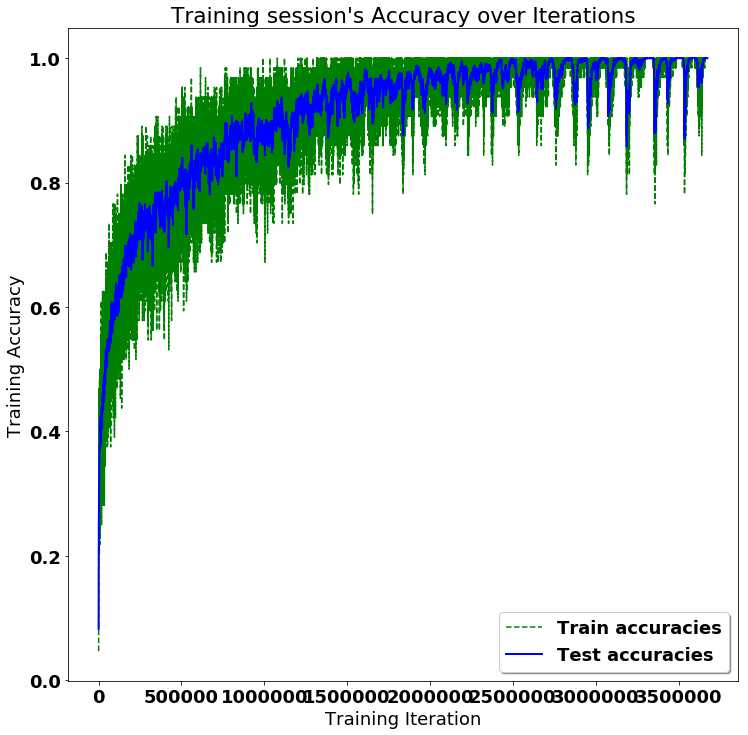

Testing Accuracy: 100.0%

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
Created using test set of 1794 datapoints, normalised to % of each class in the test dataset


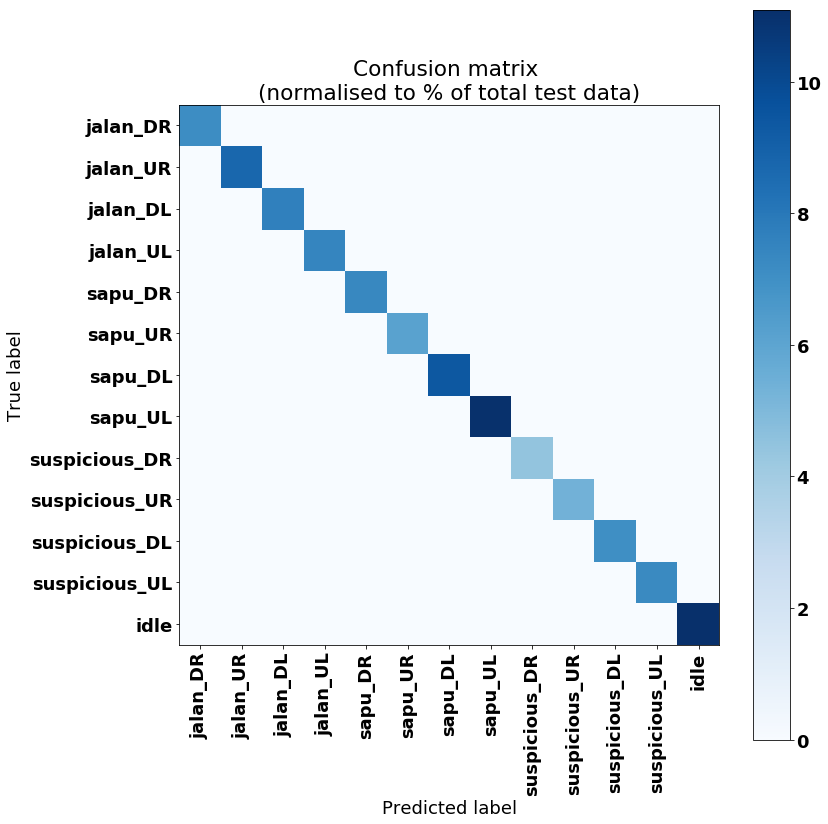

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.08249721, 0.2006689, 0.24526198, 0.27591974, 0.29988852, 0.30379042, 0.32608697, 0.3400223, 0.34336677, 0.35395762, 0.36287627, 0.3768116, 0.3768116, 0.37625417, 0.37904125, 0.3885173, 0.38350055, 0.37179488, 0.37569678, 0.39018953, 0.4180602, 0.39632106, 0.3924192, 0.3818283, 0.40022296, 0.42419174, 0.41583055, 0.4147157, 0.4253066, 0.4386845, 0.43366778, 0.42586398, 0.42196208, 0.40356743, 0.41081384, 0.41081384, 0.4052397, 0.40914157, 0.40802675, 0.41137123, 0.41137123, 0.41527313, 0.4342252, 0.43366778, 0.43756968, 0.451505, 0.45596433, 0.45652175, 0.44927537, 0.46042365, 0.45652175, 0.43756968, 0.43366778, 0.46153846, 0.4503902, 0.44481605, 0.451505, 0.44927537, 0.47658864, 0.4632107, 0.47268674, 0.48550725, 0.48662207, 0.47268674, 0.483835, 0.46544036, 0.46599776, 0.45875138, 0.48049054, 0.483835, 0.4832776, 0.49331105, 0.48550725, 0.47658864, 0.4793757, 0.4910814, 0.48662207, 0.4749164, 0.49944258, 0.49386844, 0.49554068, 0.4949833, 0.51449275, 0.50111485, 0.5167224, 0.531772

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
